National Research University "Higher School of Economics"

Master of Data Science Online Programme

Course: Modern Data Analysis: Machine Learning

Final Project: Movie success prediction model

Student: Andrei Batyrov (Fall2022)

Date: 16-Oct-2023

##### Table of Contents

1. [Description](#description)

2. [Task Formalization](#task_form)

3. [Feature Engineering](#feat_eng)

4. [Modeling](#model)

5. [Model Interpretation](#interp)

6. [Discussion](#discuss)

---
##### <a id="description"></a>1. Description

In this project, you will be asked to help a film-producing company. They would like to make sure that films, which they are creating are successful. The company has collected a large dataset, which includes information about more than 60'000 films: their description, genre, budget, rating, etc.

Your task will be to suggest and justify a way to measure the success of the film and build a machine learning model, which is capable of predicting this quantity.

In [1]:
# Essential import
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import axes3d
from scipy.stats import chi2_contingency
from scipy.stats.contingency import crosstab
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, TargetEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import tree
pd.set_option('display.max_columns', 50) # set to larger value to see all the columns of pd.DF
seed = 0

In [2]:
# Helper functions
def describe(series, kind):
    '''
    Print Pandas Series basic statistics.
    '''
    if kind == 'cat':
        print(f'{series.nunique():,.0f} unique')
        nulls = series.isna().sum()
        if nulls:
            print(f'\033[31m{nulls:,.0f} nulls\033[0m')
        else:
            print(f'{nulls:,.0f} nulls')
        print(f"{'':->20}")
        print(series.value_counts().to_string(max_rows=10, name=True))
    elif kind == 'num':
        nulls = series.isna().sum()
        if nulls:
            print(f'\033[31m{nulls:,.0f} nulls\033[0m')
        else:
            print(f'{nulls:,.0f} nulls')
        print(f"Min = {series.min():,.2f}")
        print(f"Max = {series.max():,.2f}")
        print(f"Med = {series.median():,.2f}")
    else:
        raise ValueError("kind must be 'cat' or 'num'")

In [3]:
def keep_first(df, column):
    '''
    Split column by `, ` and keep only the first value after the split
    '''
    df[column] = df[column].str.split(', ', expand=True)[0] # Keep only the first value

In [4]:
def percentile_interval(array, alpha):
    '''
    Return percentiles (boundaries) of `array`, as per the significance level `alpha`.
    '''
    boundaries = np.percentile(array, [100 * alpha / 2., 100 * (1 - alpha / 2.)]) # Two-sided percentiles
    return boundaries

In [5]:
def plot_hist(array, array2, bins, conf_lvl, xlabel, title):
    '''
    Plot two histograms side by side.
    The left histogram plots all values of `array`.
    The right histogram plots within percentiles of `array2`, as per `conf_lvl`.
    '''
    alpha = 1.0 - conf_lvl / 100
    boundaries = percentile_interval(array, alpha)
    if array2 is not None:
        plt.figure(figsize=(12, 4))
        first = 1
        num_plots = 3
        plt.subplot(1, num_plots, first)
        plt.scatter(array, array2, color='C1', marker='x', alpha=0.25)
        k, b = np.polyfit(array, array2, deg=1)
        fitted_lr = k * array + b
        plt.plot(array, fitted_lr, color='C0', ls='--', label='Fitted LR')
        plt.xlabel(f'{xlabel}', size=10, family='monospace')
        plt.ylabel(f'Target', size=10, family='monospace')
        plt.ylim([array2.min(), array2.max()])
        plt.legend()
        plt.grid(lw=0.5)
    else:
        plt.figure(figsize=(8, 4))
        first = 0
        num_plots = 2
    
    plt.subplot(1, num_plots, first + 1)
    plt.hist(array, bins=bins, color='C2', alpha=0.75, histtype='step', hatch='.'*6)
    plt.vlines(np.median(array), 0, plt.gcf().gca().get_ylim()[1], ls='--', color='C0', label=f"Med = {np.median(array):.1f}")
    plt.xlabel(f'{xlabel}\n(all values)', size=10, family='monospace')
    plt.ylabel('Count', size=10, family='monospace')
    plt.legend()
    plt.gca().set_axisbelow(True)
    plt.grid(lw=0.5)

    plt.subplot(1, num_plots, first + 2)
    plt.hist(array[np.where((array >= boundaries[0]) & (array <= boundaries[1]))], bins=bins, color='C2', alpha=0.75, histtype='step', hatch='.'*6)
    plt.vlines(np.median(array), 0, plt.gcf().gca().get_ylim()[1], ls='--', color='C0', label=f"Med = {np.median(array):.1f}")
    plt.xlabel(f'{xlabel}\n({conf_lvl}% CI)', size=10, family='monospace')
    plt.suptitle(title, size=10, family='monospace')
    plt.legend()
    plt.gca().set_axisbelow(True)
    plt.grid(lw=0.5)
    plt.tight_layout();

In [6]:
def plot_bar(df, x, y, xlabel, title, kind='vertical'):
    '''
    Plot bar plot, where `x` and `y` are column names of Pandas Dataframe `df`.
    '''
    if kind == 'vertical':
        plt.figure(figsize=(6, 4))
        bars = plt.bar(range(df[x].shape[0]), df[y].values, width=0.25, align='center', color = 'white', alpha=0.75, hatch='.'*6)
        plt.xlabel(xlabel, size=10, family='monospace')
        plt.xticks(range(df[x].shape[0]), df[x].values)
    elif kind == 'horizontal':
        plt.figure(figsize=(6, 4))
        bars = plt.barh(range(df[x].shape[0]), df[y].values, height=0.25, align='center', color = 'white', alpha=0.75, hatch='.'*6)
        plt.gca().invert_yaxis()
        plt.xlabel(xlabel, size=10, family='monospace')
        plt.yticks(range(df[x].shape[0]), df[x].values)
    else:
        raise ValueError("kind must be 'vertical' or 'horizontal'")
    for i in range(len(bars)):
        bars[i].set_edgecolor(f'C{i}')
    plt.gca().set_axisbelow(True)
    plt.grid(lw=0.5)
    plt.title(title, size=10, family='monospace');

In [7]:
def predict_partial(X, feature_name, estimator, kind, grid_size=10, conf_lvl=95):
    '''
    Calculate partial predictions for one feature with name `feature_name` in Pandas Dataframe `X`.
    Estimator can by any object that has `predict` method: model, pipeline.
    Return Pandas DataFrame with:
    - feature values used for predictions, 
    - mean predictions, 
    - Individual Conditional Expectation (ICE) percentiles, as per `conf_lvl`
    '''
    if kind not in ('num', 'cat', 'ord'):
        raise ValueError("kind must be 'num', 'cat' or 'ord'")
    grid_size = min(X[feature_name].nunique(), grid_size)
    feature_values = []
    feature_pred_means = []
    ice_los = []
    ice_his = []
    if kind == 'num':
        feature_space = np.linspace(X[feature_name].min(), X[feature_name].max(), grid_size)
    elif kind == 'cat':
        feature_space = X[feature_name].unique()[::X[feature_name].nunique() // grid_size]
    else: # kind == 'ord'
        feature_space = X[feature_name].sort_values().unique()[::X[feature_name].nunique() // grid_size]
    #print(feature_name, feature_space)
    #z = norm().ppf((1 + conf_lvl / 100) / 2)
    for feature_value in feature_space:
        feature_values.append(feature_value)
        feature_new = pd.Series([feature_value] * X.shape[0], name=feature_name) # Fix one feature value for all observations
        feature_pred = estimator.predict(pd.concat([X.drop(columns=[feature_name]).reset_index(drop=True), feature_new], axis=1))
        feature_pred_mean = feature_pred.mean()
        feature_pred_means.append(feature_pred_mean)
        ice_lo, ice_hi = percentile_interval(feature_pred, alpha=1.0-conf_lvl/100)
        ice_los.append(ice_lo)
        ice_his.append(ice_hi)
    return pd.DataFrame({'Value': feature_values, 'Pred_mean': feature_pred_means, 'ICE_lo': ice_los, 'ICE_hi': ice_his})

In [8]:
# Load data
full_dataset = pd.read_csv('IMDb movies.csv')
full_dataset.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0


---
##### <a id="task_form"></a>2. Task Formalization

Task formalization and Evaluation criteria

2.1. Select your target variable, explain your choice. Separate target variable from the feature matrix.

In [9]:
full_dataset.shape

(60198, 22)

In [10]:
# All columns
full_dataset.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

In [11]:
# Check nulls
full_dataset.isna().sum()

imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                      5
language                   480
director                    24
writer                     808
production_company        2744
actors                      30
description               1993
avg_vote                     0
votes                        0
budget                   43379
usa_gross_income         48306
worlwide_gross_income    41062
metascore                51386
reviews_from_users        4069
reviews_from_critics      8229
dtype: int64

Let's check all columns, if they might be either a predictor or the target.

|  n | Column                  | Predictor      | Target         |
|---:|-------------------------|----------------|----------------|
|  1 | `imdb_title_id`         | No<sup>1</sup> | No<sup>3</sup> |
|  2 | `title`                 | No<sup>1</sup> | No<sup>3</sup> |
|  3 | `original_title`        | No<sup>1</sup> | No<sup>3</sup> |
|  4 | `year`                  | Yes            | No<sup>3</sup> |
|  5 | `date_published`        | Yes            | No<sup>3</sup> |
|  6 | `genre`                 | Yes            | No<sup>3</sup> |
|  7 | `duration`              | Yes            | No<sup>3</sup> |
|  8 | `country`               | Yes            | No<sup>3</sup> |
|  9 | `language`              | Yes            | No<sup>3</sup> |
| 10 | `director`              | Yes            | No<sup>3</sup> |
| 11 | `writer`                | Yes            | No<sup>3</sup> |
| 12 | `production_company`    | Yes            | No<sup>3</sup> |
| 13 | `actors`                | Yes            | No<sup>3</sup> |
| 14 | `description`           | Yes            | No<sup>3</sup> |
| 15 | `avg_vote`              | Yes<sup>2</sup>| Yes            |
| 16 | `votes`                 | Yes<sup>2</sup>| No<sup>3</sup> |
| 17 | `budget`                | Yes            | No<sup>3</sup> |
| 18 | `usa_gross_income`      | Yes<sup>2</sup>| Yes            |
| 19 | `worlwide_gross_income` | Yes<sup>2</sup>| Yes            |
| 20 | `metascore`             | Yes<sup>2</sup>| Yes            |
| 21 | `reviews_from_users`    | Yes<sup>2</sup>| No<sup>3</sup> |
| 22 | `reviews_from_critics`  | Yes<sup>2</sup>| No<sup>3</sup> |

<sup>1</sup> Movies can be considered as independent objects with identically distributed properties, i.e. movies are tuples of i.i.d. random variables. In this case, columns with auto-incremented or otherwise sorted values such as id or title are not valuable predictors.

<sup>2</sup> Warning: Normally, we do not have this information before the release of a movie, so using these predictors might cause a phenomenon called target leakage: use of information in the model training process which is not expected to be available at prediction time. However, for simplicity, let's assume that these variables do not cause target leakage.

<sup>3</sup> This column does not look like a measure of success: it should be box office (money), score, relative rating, or something like that.

So, we have four candidates for the target: `avg_vote`, `usa_gross_income`, `worlwide_gross_income`, and `metascore`.

In [12]:
# Possible targets' missing values: fraction of all observations
full_dataset[['avg_vote', 'usa_gross_income', 'worlwide_gross_income', 'metascore']].isna().sum() / \
full_dataset[['avg_vote', 'usa_gross_income', 'worlwide_gross_income', 'metascore']].shape[0]

avg_vote                 0.000000
usa_gross_income         0.802452
worlwide_gross_income    0.682116
metascore                0.853616
dtype: float64

Only `avg_vote` has no missing values, while the other three columns have very high fraction of missing values. __So, our target will be `avg_vote`.__

2.2. Explain which task are you going to solve (is it a regression, classification or something else)? 

0 nulls
Min = 1.00
Max = 10.00
Med = 6.20


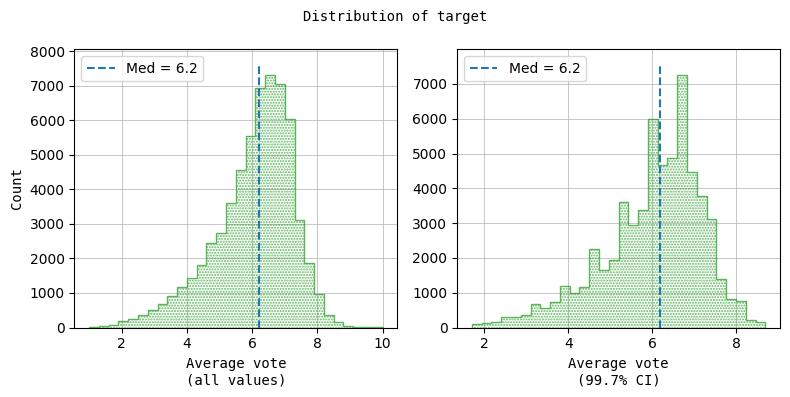

In [13]:
# Examine the target
target = 'avg_vote'
describe(full_dataset[target], 'num')
plot_hist(full_dataset[target].values, None, 30, 99.7, 'Average vote', 'Distribution of target')

As per the distribution above, the target looks like a continuous variable with the following properties:
- having somewhat close to normal distribution, 
- having only one central tendency (one mode),
- having no extreme outliers.

__Based on that, we are looking at the `regression` problem, that is predicting a real value.__

2.3. Select a metric. Is it already implemented in sklearn? If yes, import it. If not, it is time to write a function which will calculate it. 

For regression problem, normally metrics for continuous target variable are used to estimate the quality of predictions, such as Coefficient of determination $R^2$, or Mean Squared Error (MSE) / Root Mean Squared Error (RMSE).

__Let's choose $R^2$ score__, since it is easy to interpret: it shows what proportion of variance of the dependent variable $y$ the model can explain. For example, $R^2$ = 0.5 indicates that 50% of change of $y$ can be explained by the suggested model (features). The higher the $R^2$, the better the model can predict the target. Since it is a relative score, lying in the interval $[0, 1]$, it  allows for model comparison and selection. $R^2$ score is implemented in `sklearn` as the `score()` method of all regression models.

---
##### <a id="feat_eng"></a>3. Feature Engineering

Explore and preprocess the data

3.1. Explore you data: make plots, print tables. Make sure to write your observations. Do not forget to fill-in missing values, define relevant columns transformations

Now, let's look closer at our predictors (features).

In [14]:
# 1. Year
describe(full_dataset['year'], 'cat')

110 unique
0 nulls
--------------------
year
2009    2250
2010    2155
2008    2110
2007    2044
2006    2031
        ... 
1914      21
1913      13
1912       5
1911       4
1906       1
Name: count


Pearson corr coef with target = -0.23
0 nulls
Min = 1,906.00
Max = 2,019.00
Med = 1,992.00


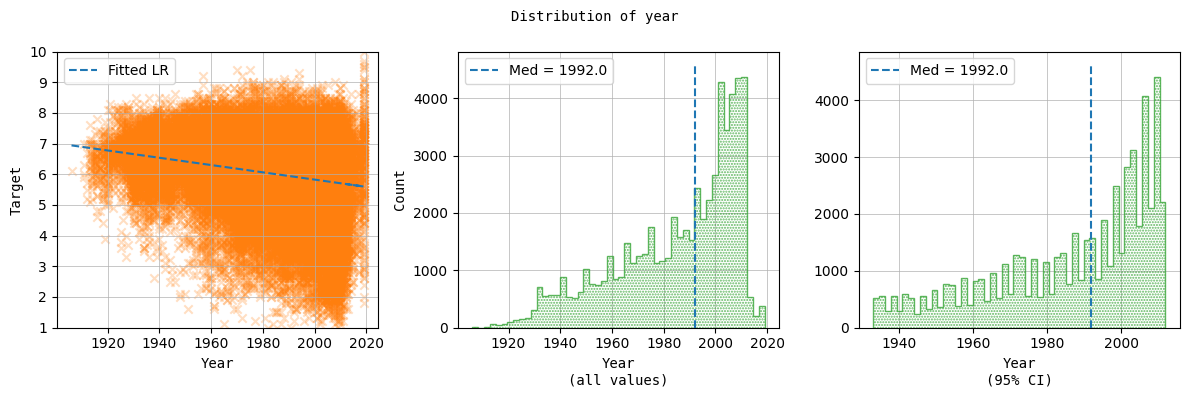

In [15]:
print(f"Pearson corr coef with target = {full_dataset['year'].corr(full_dataset[target]):.2f}")
describe(full_dataset['year'], 'num')
plot_hist(full_dataset['year'].values, full_dataset[target].values, 50, 95, 'Year', 'Distribution of year')

`year` looks like an ordinal variable with expected heavy left tails (movie production is only increasing with time). It is rather loosely correlated with target. Interestingly, this correlation is negative: later movies have lower target. Another interesting fact about this variable is that half of the movies were produced between 1906 and 1992 (over 86 years), while the other half between 1992 and 2019 (over 27 years), so movie production is increasing indeed. We will use it in our model.

In [16]:
# 2. Date published and its date components
describe(full_dataset['date_published'], 'cat')

19,431 unique
0 nulls
--------------------
date_published
2010          101
1999          101
2008           99
1997           91
1996           88
             ... 
1966-09-12      1
1967-02-16      1
1966-01-04      1
1970-03-05      1
2015-04-10      1
Name: count


In [17]:
full_dataset['date_published_year'] = pd.DatetimeIndex(pd.to_datetime(full_dataset['date_published'], errors='ignore')).year
full_dataset['date_published_month'] = pd.DatetimeIndex(pd.to_datetime(full_dataset['date_published'], errors='ignore')).month
full_dataset['date_published_day'] = pd.DatetimeIndex(pd.to_datetime(full_dataset['date_published'], errors='ignore')).day

Pearson corr coef with target = -0.23
0 nulls
Min = 1,906.00
Max = 2,020.00
Med = 1,993.00


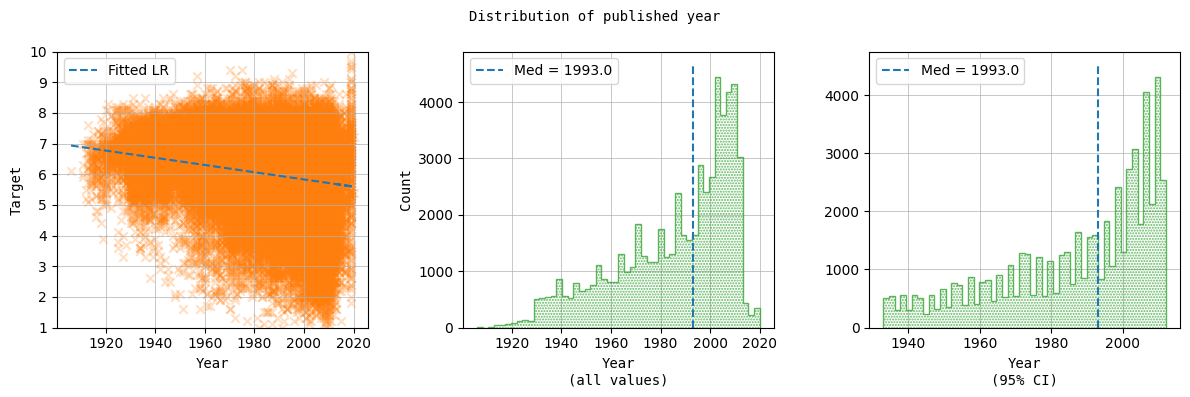

In [18]:
print(f"Pearson corr coef with target = {full_dataset['date_published_year'].corr(full_dataset[target]):.2f}")
describe(full_dataset['date_published_year'], 'num')
plot_hist(full_dataset['date_published_year'].values, full_dataset[target].values, 50, 95, 'Year', 'Distribution of published year')

Pearson corr coef with target = 0.03
0 nulls
Min = 1.00
Max = 12.00
Med = 6.00


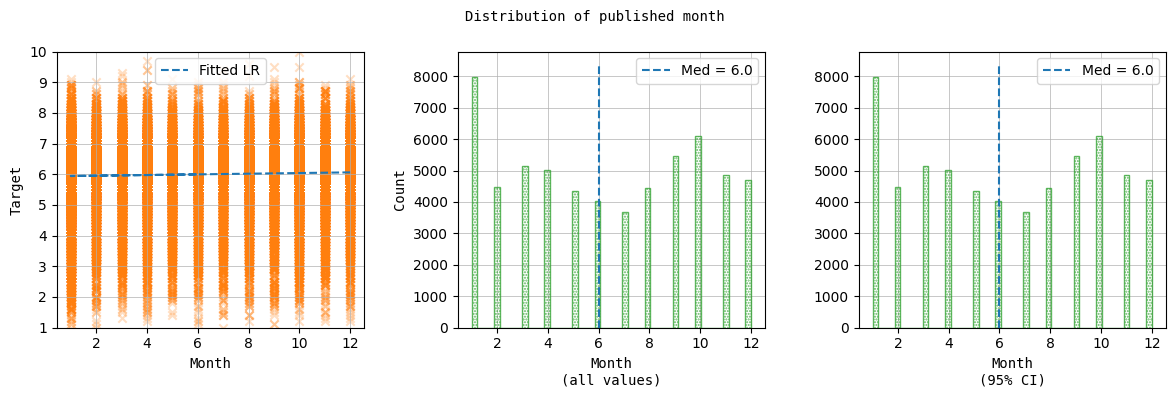

In [19]:
print(f"Pearson corr coef with target = {full_dataset['date_published_month'].corr(full_dataset[target]):.2f}")
describe(full_dataset['date_published_month'], 'num')
plot_hist(full_dataset['date_published_month'].values, full_dataset[target].values, 50, 95, 'Month', 'Distribution of published month')

Pearson corr coef with target = 0.06
0 nulls
Min = 1.00
Max = 31.00
Med = 14.00


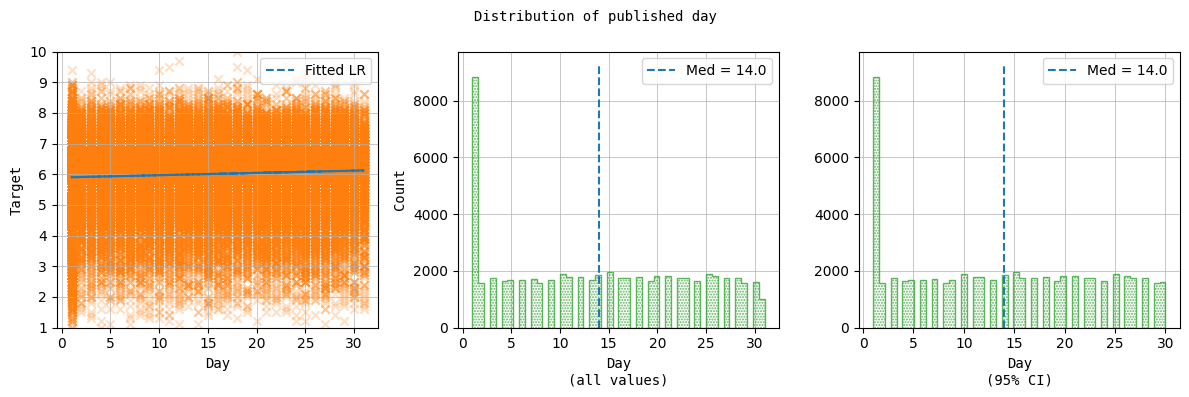

In [20]:
print(f"Pearson corr coef with target = {full_dataset['date_published_day'].corr(full_dataset[target]):.2f}")
describe(full_dataset['date_published_day'], 'num')
plot_hist(full_dataset['date_published_day'].values, full_dataset[target].values, 50, 95, 'Day', 'Distribution of published day')

`date_published`'s extracted date components look like ordinal variables. Only published year is rather loosely correlated with target, while month and day do not seem to be correlated with the target. We will use only the published year in our model.

Pearson corr coef with target = 0.23
0 nulls
Min = 40.00
Max = 729.00
Med = 95.00


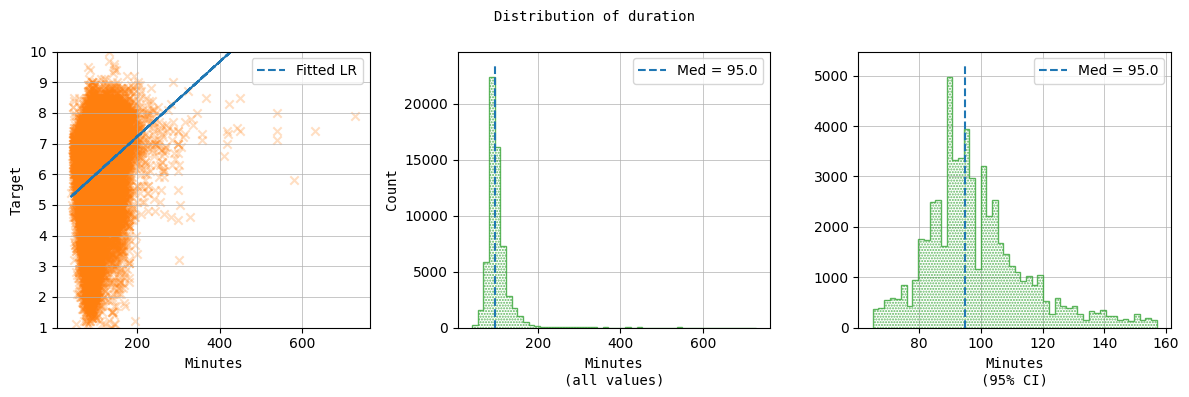

In [21]:
# 3. Duration
print(f"Pearson corr coef with target = {full_dataset['duration'].corr(full_dataset[target]):.2f}")
describe(full_dataset['duration'], 'num')
plot_hist(full_dataset['duration'].values, full_dataset[target].values, 50, 95, 'Minutes', 'Distribution of duration')

`duration` looks like a continuous variable with somewhat close to normal 95% part of the distribution and expected heavy right tails (there are always very long movies). It is rather loosely correlated with target. Interestingly, this correlation is positive: the longer the movie, the higher the target. We will use it in our model.

In [22]:
# 4. Genre
describe(full_dataset['genre'], 'cat')

1,202 unique
0 nulls
--------------------
genre
Drama                      8498
Comedy                     5420
Comedy, Drama              2654
Drama, Romance             2529
Comedy, Romance            1777
                           ... 
Adult, Crime, Horror          1
Horror, Thriller, Crime       1
Thriller, Sci-Fi, Drama       1
War, Action, Comedy           1
Animation, Sport              1
Name: count


This is a categorical feature with many unique values. Also, some of the movies have several genres. It is reasonable to:
- keep only the first genre, making an assumption that the first genre is the most important,
- fill missing values (if any) with a constant value `Unknown`.

In [23]:
keep_first(full_dataset, 'genre')
# Fill null values with a constant value `Unknown`
full_dataset['genre'].fillna('Unknown', inplace=True)
describe(full_dataset['genre'], 'cat')

23 unique
0 nulls
--------------------
genre
Drama          17565
Comedy         17350
Action          8360
Crime           4228
Horror          3215
               ...  
History           52
Film-Noir         34
Sport              4
Adult              2
Documentary        2
Name: count


Now let's check association between `genre` and target by using $\chi^2$-test. The target is a continuous variable so first, we need to bucket it into some number of categories, let's use 10 categories. Also, note, that for all $\chi^2$-tests below, for simplicity, we'll rather ignore the requirement of more than 5 counts in the contingency table cells.

In [24]:
target_labels = [f'{str(i)}-{str(i+1)}' for i in range(10)]
full_dataset['avg_vote_bucket'] = pd.cut(full_dataset[target], bins=range(11), labels=target_labels)
full_dataset[['avg_vote', 'avg_vote_bucket']].iloc[np.random.choice(full_dataset.shape[0], 5)]

,avg_vote,avg_vote_bucket
42806,7.8,7-8
15817,6.2,6-7
12062,5.2,5-6
40836,6.1,6-7
13146,8.0,7-8


In [25]:
observed_df = pd.DataFrame(crosstab(full_dataset['genre'], full_dataset['avg_vote_bucket']).count)
df_index = full_dataset['genre'].value_counts().index.sort_values()
df_columns = full_dataset['avg_vote_bucket'].value_counts().index.sort_values()
observed_df.index = df_index
observed_df.columns = df_columns
observed_df.iloc[np.random.choice(observed_df.shape[0], 5)]

avg_vote_bucket,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10
genre,,,,,,,,,,
History,0,0,3,0,3,15,22,8,1,0
Documentary,0,0,0,0,0,0,2,0,0,0
Musical,0,0,3,7,20,95,118,45,5,0
Horror,0,44,289,619,872,857,452,79,3,0
Crime,0,5,46,134,370,949,1896,769,58,1


In [26]:
chi2_test_result = chi2_contingency(observed_df.values)
print(f'{chi2_test_result.pvalue = } (assuming significance level = 0.05)')

chi2_test_result.pvalue = 0.0 (assuming significance level = 0.05)


We have confirmed that `genre` and target are not independent indeed, thus we will use this feature in our model.

In [27]:
# 5. Country
describe(full_dataset['country'], 'cat')

3,318 unique
5 nulls
--------------------
country
USA                                  22080
India                                 3041
UK                                    2992
France                                2330
Japan                                 2132
                                     ...  
Canada, UK, France, Italy                1
Finland, Germany, Sweden, Denmark        1
Sri Lanka, Japan                         1
France, UK, Germany, Hungary             1
UK, Germany, Australia                   1
Name: count


This is a categorical feature with many unique values. Also, some of the movies have several countries. It is reasonable to:
- keep only the first country, making an assumption that the first country is the most important,
- fill missing values (if any) with a constant value `Unknown`.

In [28]:
keep_first(full_dataset, 'country')
# Fill null values with a constant value `Unknown`
full_dataset['country'].fillna('Unknown', inplace=True)
describe(full_dataset['country'], 'cat')

140 unique
0 nulls
--------------------
country
USA              23832
UK                4365
France            3910
India             3102
Italy             3012
                 ...  
Nicaragua            1
Suriname             1
Côte d'Ivoire        1
Syria                1
Uganda               1
Name: count


Now let's check association between `country` and target by using $\chi^2$-test. As with `genre`, we'll use target buckets.

In [29]:
observed_df = pd.DataFrame(crosstab(full_dataset['country'], full_dataset['avg_vote_bucket']).count)
df_index = full_dataset['country'].value_counts().index.sort_values()
df_columns = full_dataset['avg_vote_bucket'].value_counts().index.sort_values()
observed_df.index = df_index
observed_df.columns = df_columns
observed_df.iloc[np.random.choice(observed_df.shape[0], 5)]

avg_vote_bucket,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10
country,,,,,,,,,,
Iraq,0,0,0,0,0,1,3,2,0,0
Malta,0,1,0,2,0,0,0,0,0,0
Japan,0,4,10,18,98,317,1121,654,45,0
Serbia,0,0,1,3,6,18,34,15,5,0
Angola,0,0,0,0,0,0,4,0,0,0


In [30]:
chi2_test_result = chi2_contingency(observed_df.values)
print(f'{chi2_test_result.pvalue = } (assuming significance level = 0.05)')

chi2_test_result.pvalue = 0.0 (assuming significance level = 0.05)


We have confirmed that `country` and target are not independent indeed, thus we will use this feature in our model.

In [31]:
# 6. Language
describe(full_dataset['language'], 'cat')

3,191 unique
480 nulls
--------------------
language
English                                          27008
French                                            2972
Italian                                           2202
Japanese                                          1915
Spanish                                           1837
                                                 ...  
English, Danish, Serbo-Croatian                      1
English, Serbo-Croatian, Spanish, Czech              1
French, Spanish, Japanese                            1
English, German, Finnish, Japanese, Cantonese        1
Turkish, Kurdish, Bosnian                            1
Name: count


This is a categorical feature with many unique values. Also, some of the movies have several languages. It is reasonable to:
- keep only the first language, making an assumption that the first language is the most important,
- fill missing values (if any) with a constant value `Unknown`.

In [32]:
keep_first(full_dataset, 'language')
# Fill null values with a constant value `Unknown`
full_dataset['language'].fillna('Unknown', inplace=True)
describe(full_dataset['language'], 'cat')

145 unique
0 nulls
--------------------
language
English                  32342
French                    3984
Italian                   2619
Spanish                   2206
Japanese                  2175
                         ...  
Burmese                      1
Spanish Sign Language        1
Sardinian                    1
Rotuman                      1
Quechua                      1
Name: count


Now let's check association between `language` and target by using $\chi^2$-test. As with `genre`, we'll use target buckets.

In [33]:
observed_df = pd.DataFrame(crosstab(full_dataset['language'], full_dataset['avg_vote_bucket']).count)
df_index = full_dataset['language'].value_counts().index.sort_values()
df_columns = full_dataset['avg_vote_bucket'].value_counts().index.sort_values()
observed_df.index = df_index
observed_df.columns = df_columns
observed_df.iloc[np.random.choice(observed_df.shape[0], 5)]

avg_vote_bucket,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10
language,,,,,,,,,,
Albanian,0,0,1,1,0,0,7,8,1,0
Bulgarian,0,0,0,0,2,2,25,46,19,1
Azerbaijani,0,0,0,0,0,1,0,10,8,0
Mongolian,0,0,0,0,0,0,4,4,0,0
Norwegian,0,2,3,4,38,91,119,24,1,0


In [34]:
chi2_test_result = chi2_contingency(observed_df.values)
print(f'{chi2_test_result.pvalue = } (assuming significance level = 0.05)')

chi2_test_result.pvalue = 0.0 (assuming significance level = 0.05)


We have confirmed that `language` and target are not independent indeed, thus we will use this feature in our model.

In [35]:
# 7. Director
describe(full_dataset['director'], 'cat')

22,771 unique
24 nulls
--------------------
director
Michael Curtiz                        86
Jesús Franco                          85
Lloyd Bacon                           73
William Beaudine                      69
Richard Thorpe                        67
                                      ..
Abolfazl Jalili, Mohsen Makhmalbaf     1
Stein Leikanger                        1
Ishirô Honda, Terry O. Morse           1
Steve Procko                           1
Barry Battles                          1
Name: count


This is a categorical feature with many unique values. Also, some of the movies have several directors. It is reasonable to:
- keep only the first director, making an assumption that the first director is the most important,
- fill missing values (if any) with a constant value `Unknown`.

In [36]:
keep_first(full_dataset, 'director')
# Fill null values with a constant value `Unknown`
full_dataset['director'].fillna('Unknown', inplace=True)
describe(full_dataset['director'], 'cat')

21,052 unique
0 nulls
--------------------
director
Michael Curtiz        92
Jesús Franco          90
Lloyd Bacon           77
John Ford             73
William Beaudine      72
                      ..
Hassan Yektapanah      1
Frank Longo            1
Jean-Michel Barjol     1
James Anderson         1
Barry Battles          1
Name: count


Now let's check association between `director` and target by using $\chi^2$-test. As with `genre`, we'll use target buckets.

In [37]:
observed_df = pd.DataFrame(crosstab(full_dataset['director'], full_dataset['avg_vote_bucket']).count)
df_index = full_dataset['director'].value_counts().index.sort_values()
df_columns = full_dataset['avg_vote_bucket'].value_counts().index.sort_values()
observed_df.index = df_index
observed_df.columns = df_columns
observed_df.iloc[np.random.choice(observed_df.shape[0], 5)]

avg_vote_bucket,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10
director,,,,,,,,,,
Chad Archibald,0,0,0,0,1,0,0,0,0,0
Madonna,0,0,0,0,0,1,1,0,0,0
Giuseppe Moccia,0,0,1,0,0,0,0,0,0,0
Perry Lang,0,0,0,0,0,1,0,0,0,0
Luis Cámara,0,0,0,0,1,0,0,0,0,0


In [38]:
chi2_test_result = chi2_contingency(observed_df.values)
print(f'{chi2_test_result.pvalue = } (assuming significance level = 0.05)')

chi2_test_result.pvalue = 0.0 (assuming significance level = 0.05)


We have confirmed that `director` and target are not independent indeed, thus we will use this feature in our model.

In [39]:
# 8. Writer
describe(full_dataset['writer'], 'cat')

47,546 unique
808 nulls
--------------------
writer
Jing Wong                                70
Kuang Ni                                 44
Woody Allen                              33
Cheh Chang, Kuang Ni                     32
Leonardo Benvenuti, Piero De Bernardi    32
                                         ..
Lino Banfi, Romolo Guerrieri              1
Adam Brooks, Mark Horowitz                1
Gregory K. Heller, Amos Poe               1
Max Jack, Elmore Leonard                  1
Barry Battles, Griffin Hood               1
Name: count


This is a categorical feature with many unique values. Also, some of the movies have several writers. It is reasonable to:
- keep only the first writer, making an assumption that the first writer is the most important,
- fill missing values (if any) with a constant value `Unknown`.

In [40]:
keep_first(full_dataset, 'writer')
# Fill null values with a constant value `Unknown`
full_dataset['writer'].fillna('Unknown', inplace=True)
describe(full_dataset['writer'], 'cat')

30,202 unique
0 nulls
--------------------
writer
Unknown            808
Jing Wong           76
Jesús Franco        55
Kuang Ni            52
Robin Bhatt         46
                  ... 
Anil Ajitabh         1
John Mollica         1
Erich Hoeber         1
Goran Rusinovic      1
Barry Battles        1
Name: count


Now let's check association between `writer` and target by using $\chi^2$-test. As with `genre`, we'll use target buckets.

In [41]:
observed_df = pd.DataFrame(crosstab(full_dataset['writer'], full_dataset['avg_vote_bucket']).count)
df_index = full_dataset['writer'].value_counts().index.sort_values()
df_columns = full_dataset['avg_vote_bucket'].value_counts().index.sort_values()
observed_df.index = df_index
observed_df.columns = df_columns
observed_df.iloc[np.random.choice(observed_df.shape[0], 5)]

avg_vote_bucket,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10
writer,,,,,,,,,,
Marc Fienberg,0,0,0,0,0,0,1,0,0,0
Don Henderson,0,0,0,0,0,1,0,0,0,0
Andreas Markus Klug,0,0,0,0,0,0,1,0,0,0
Julien Duvivier,0,0,0,0,0,1,5,6,0,0
Isaac H. Eaton,0,0,0,0,0,1,0,0,0,0


In [42]:
chi2_test_result = chi2_contingency(observed_df.values)
print(f'{chi2_test_result.pvalue = } (assuming significance level = 0.05)')

chi2_test_result.pvalue = 0.0 (assuming significance level = 0.05)


We have confirmed that `writer` and target are not independent indeed, thus we will use this feature in our model.

In [43]:
# 9. Production Company
describe(full_dataset['production_company'], 'cat')

21,441 unique
2,744 nulls
--------------------
production_company
Metro-Goldwyn-Mayer (MGM)    1277
Warner Bros.                 1116
Columbia Pictures             863
Paramount Pictures            857
Twentieth Century Fox         839
                             ... 
Stefi & Lynx Productoins        1
Van Peebles Films               1
Kiss and Tell                   1
LDPI Productions                1
Animate Projects Limited        1
Name: count


This is a categorical feature with many unique values. Also, some of the movies have several production companies. It is reasonable to:
- keep only the first production company, making an assumption that the first production company is the most important,
- fill missing values (if any) with a constant value `Unknown`.

In [44]:
keep_first(full_dataset, 'production_company')
# Fill null values with a constant value `Unknown`
full_dataset['production_company'].fillna('Unknown', inplace=True)
describe(full_dataset['production_company'], 'cat')

21,437 unique
0 nulls
--------------------
production_company
Unknown                      2744
Metro-Goldwyn-Mayer (MGM)    1277
Warner Bros.                 1116
Columbia Pictures             863
Paramount Pictures            857
                             ... 
Remington York Inc.             1
Stefi & Lynx Productoins        1
Van Peebles Films               1
Kiss and Tell                   1
Animate Projects Limited        1
Name: count


Now let's check association between `production_company` and target by using $\chi^2$-test. As with `genre`, we'll use target buckets.

In [45]:
observed_df = pd.DataFrame(crosstab(full_dataset['production_company'], full_dataset['avg_vote_bucket']).count)
df_index = full_dataset['production_company'].value_counts().index.sort_values()
df_columns = full_dataset['avg_vote_bucket'].value_counts().index.sort_values()
observed_df.index = df_index
observed_df.columns = df_columns
observed_df.iloc[np.random.choice(observed_df.shape[0], 5)]

avg_vote_bucket,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10
production_company,,,,,,,,,,
Sveriges Folkbiografer,0,0,0,0,0,0,2,0,0,0
Artists Complex Pictures,0,0,0,0,1,0,0,0,0,0
Albion Films,0,0,0,1,0,0,0,0,0,0
Evini Films,0,0,0,0,0,0,0,1,0,0
Casablanca Producciones S.A.,0,0,0,0,0,1,0,0,0,0


In [46]:
chi2_test_result = chi2_contingency(observed_df.values)
print(f'{chi2_test_result.pvalue = } (assuming significance level = 0.05)')

chi2_test_result.pvalue = 0.0 (assuming significance level = 0.05)


We have confirmed that `production_company` and target are not independent indeed, thus we will use this feature in our model.

In [47]:
# 10. Actors
describe(full_dataset['actors'], 'cat')

60,145 unique
30 nulls
--------------------
actors
Nobuyo Ôyama, Noriko Ohara, Michiko Nomura, Kaneta Kimotsuki, Kazuya Tatekabe                                                                                                                                                                                                    13
Priscilla Alden, Michael Flood, Jane Lambert, Robert Copple, George 'Buck' Flower, Ginna Martine, Cliff McDonald, Charles Egan, Sonny La Rocca, Sandra Shotwell, Lisa Farros                                                                                                      2
Kaj Andersson, Tove Hellbom, Jan Erik Husbom, Tomas Johansson, Elisabeth Nordkvist, Lena Wixell, Kim Åsberg                                                                                                                                                                       2
Linda Bergström, Crispin Dickson Wendenius, Henrik Larsson, Ellen Demérus, Anna Sahlin, Harald Lönnbro, Tove Edfeldt, Eli

This is a categorical feature with many unique values. Also, some of the movies have several actors. This is not an NLP assignment, so for the sake of simplicity, it is reasonable to:
- keep only the first actor, making an assumption that the first actor is the most important,
- fill missing values (if any) with a constant value `Unknown`.

In [48]:
keep_first(full_dataset, 'actors')
# Fill null values with a constant value `Unknown`
full_dataset['actors'].fillna('Unknown', inplace=True)
describe(full_dataset['actors'], 'cat')

25,082 unique
0 nulls
--------------------
actors
Mohanlal               115
John Wayne             111
Amitabh Bachchan        95
Andy Lau                69
Kemal Sunal             69
                      ... 
Theresa Constantine      1
Dixie Donovan            1
Robin Lane               1
Jason Brouwer            1
Quynh Hoa                1
Name: count


Now let's check association between `actors` and target by using $\chi^2$-test. As with `genre`, we'll use target buckets.

In [49]:
observed_df = pd.DataFrame(crosstab(full_dataset['actors'], full_dataset['avg_vote_bucket']).count)
df_index = full_dataset['actors'].value_counts().index.sort_values()
df_columns = full_dataset['avg_vote_bucket'].value_counts().index.sort_values()
observed_df.index = df_index
observed_df.columns = df_columns
observed_df.iloc[np.random.choice(observed_df.shape[0], 5)]

avg_vote_bucket,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10
actors,,,,,,,,,,
Vasilis Diamantopoulos,0,0,0,0,0,0,0,0,1,0
Moby,0,0,0,0,1,0,0,0,0,0
Adile Nasit,0,0,0,0,0,0,1,0,0,0
Inka Friedrich,0,0,0,0,0,0,1,0,0,0
Nick Tagas,0,0,0,0,1,0,0,0,0,0


In [50]:
chi2_test_result = chi2_contingency(observed_df.values)
print(f'{chi2_test_result.pvalue = } (assuming significance level = 0.05)')

chi2_test_result.pvalue = 0.0 (assuming significance level = 0.05)


We have confirmed that `actors` and target are not independent indeed, thus we will use this feature in our model.

In [51]:
# 11. Description
describe(full_dataset['description'], 'cat')

58,126 unique
1,993 nulls
--------------------
description
Mail                                                                                                                                                                                                                                   7
The story of                                                                                                                                                                                                                           6
Based on                                                                                                                                                                                                                               6
Emil goes to Berlin to see his grandmother with a large amount of money and is offered sweets by a strange man that make him sleep. He wakes up at his stop with no money. It is up to him and a group of children to save the day.    4
Dr. Henry

This is a categorical feature with many unique values. This is not an NLP assignment, so we will not make any assumptions about importance of all or some values of this variable, and for the sake of simplicity, we will not use it in our model. Instead we can try to introduce a new variable: the length of the description text in characters. The null hypothesis regarding this new feature is that it is not correlated with the target, and the alternative is that they are correlated.

In [52]:
full_dataset['description_len'] = full_dataset['description'].str.len()

Pearson corr coef with target = -0.03
1,993 nulls
Min = 2.00
Max = 402.00
Med = 179.00


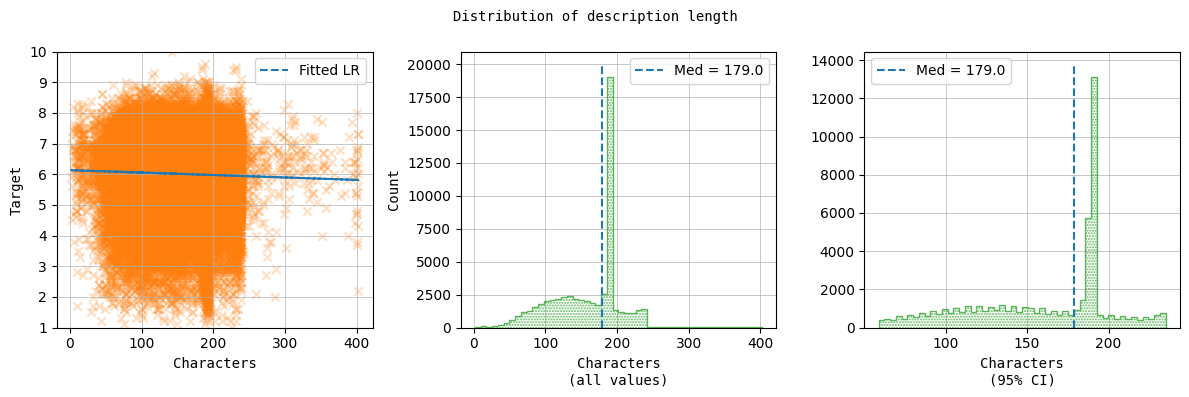

In [53]:
print(f"Pearson corr coef with target = {full_dataset['description_len'].corr(full_dataset[target]):.2f}")
describe(full_dataset['description_len'], 'num')
plot_hist(full_dataset.dropna(subset='description_len')['description_len'].values, full_dataset.dropna(subset='description_len')[target].values, 50, 95, 'Characters', 'Distribution of description length')

Our new variable does not look good: it has a very sharp spike around 200 characters and almost no descriptions with 250+ characters. In fact, this variable looks like it was truncated, corrupted, or otherwise transformed. Also, it does not seem to be correlated with the target, so we will not reject the null hypothesis, and thus will _not_ use it in our model.

Pearson corr coef with target = 0.17
0 nulls
Min = 100.00
Max = 2,159,628.00
Med = 503.00


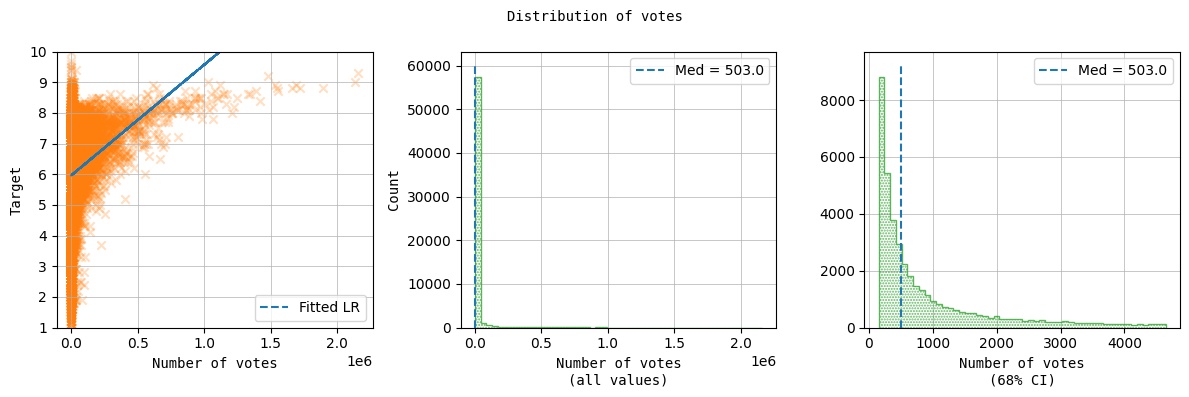

In [54]:
# 12. Votes
print(f"Pearson corr coef with target = {full_dataset['votes'].corr(full_dataset[target]):.2f}")
describe(full_dataset['votes'], 'num')
plot_hist(full_dataset['votes'].values, full_dataset[target].values, 50, 68, 'Number of votes', 'Distribution of votes')

`votes` looks like a continuous variable with expected heavy right tails (there are always extraordinary movies with many votes). It is rather loosely correlated with target. This correlation is positive: the larger the number of votes, the higher the target. We will use it in our model.

In [55]:
# 13. Budget and its currency and value components
describe(full_dataset['budget'], 'cat')

3,503 unique
43,379 nulls
--------------------
budget
$ 1000000     512
$ 2000000     423
$ 5000000     376
$ 3000000     368
$ 10000000    350
             ... 
$ 810000        1
DEM 260000      1
CAD 910000      1
AUD 240000      1
CAD 88000       1
Name: count


In [56]:
full_dataset['budget_currency'] = full_dataset['budget'].str.split('\s', expand=True)[0]
full_dataset['budget_value'] = full_dataset['budget'].str.split('\s', expand=True)[1].astype(float)
# Fill null values with a constant value `Unknown`
full_dataset['budget_currency'].fillna('Unknown', inplace=True)

In [57]:
describe(full_dataset['budget_currency'], 'cat')

69 unique
0 nulls
--------------------
budget_currency
Unknown    43379
$          12816
EUR         1216
CAD          511
GBP          470
           ...  
GRD            1
JMD            1
ATS            1
BND            1
VEB            1
Name: count


In [58]:
observed_df = pd.DataFrame(crosstab(full_dataset['budget_currency'], full_dataset['avg_vote_bucket']).count)
df_index = full_dataset['budget_currency'].value_counts().index.sort_values()
df_columns = full_dataset['avg_vote_bucket'].value_counts().index.sort_values()
observed_df.index = df_index
observed_df.columns = df_columns
observed_df.iloc[np.random.choice(observed_df.shape[0], 5)]

avg_vote_bucket,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10
budget_currency,,,,,,,,,,
CHF,0,0,0,1,0,4,7,0,0,0
PKR,0,0,0,0,0,1,0,1,0,0
ESP,0,0,0,2,4,7,13,7,0,0
NPR,0,0,0,0,0,0,1,0,0,0
GRD,0,0,0,0,0,0,0,1,0,0


In [59]:
chi2_test_result = chi2_contingency(observed_df.values)
print(f'{chi2_test_result.pvalue = } (assuming significance level = 0.05)')

chi2_test_result.pvalue = 7.010025474461906e-118 (assuming significance level = 0.05)


Pearson corr coef with target = 0.02
43,379 nulls
Min = 2.00
Max = 30,000,000,000.00
Med = 3,500,000.00


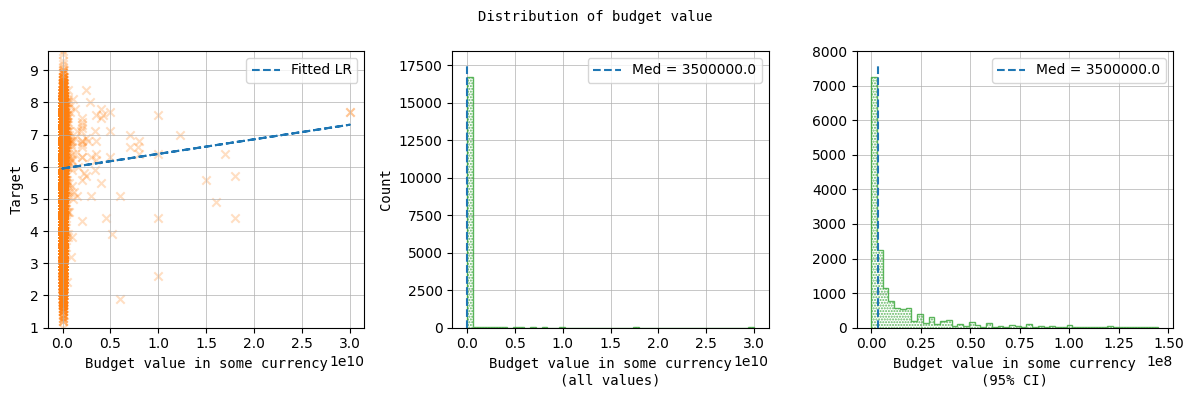

In [60]:
print(f"Pearson corr coef with target = {full_dataset['budget_value'].corr(full_dataset[target]):.2f}")
describe(full_dataset['budget_value'], 'num')
plot_hist(full_dataset.dropna(subset='budget')['budget_value'].values, full_dataset.dropna(subset='budget')[target].values, 50, 95, 'Budget value in some currency', 'Distribution of budget value')

`budget_value` has too many missing values and it does not seem to be correlated with the target. Even though, `budget_currency` seems to be associated with the target, we will _not_ use both of the variables, since they are connected. In fact, this was expected, since `budget_value` is in various currencies with different exchange rates; also money value has changed drastically over time due to inflation, denomination etc.

In [61]:
# 14. USA gross income and its currency and value components
describe(full_dataset['usa_gross_income'], 'cat')

11,529 unique
48,306 nulls
--------------------
usa_gross_income
$ 1000000     19
$ 1500000     18
$ 8144        18
$ 509         14
$ 1400000     13
              ..
$ 1760527      1
$ 30806194     1
$ 10424645     1
$ 26381221     1
$ 258656       1
Name: count


In [62]:
full_dataset['usa_gross_income_currency'] = full_dataset['usa_gross_income'].str.split('\s', expand=True)[0]
full_dataset['usa_gross_income_value'] = full_dataset['usa_gross_income'].str.split('\s', expand=True)[1].astype(float)
# Fill null values with a constant value `Unknown`
full_dataset['usa_gross_income_currency'].fillna('Unknown', inplace=True)

In [63]:
describe(full_dataset['usa_gross_income_currency'], 'cat')

5 unique
0 nulls
--------------------
usa_gross_income_currency
Unknown    48306
$          11887
GBP            3
EUR            1
HKD            1
Name: count


In [64]:
observed_df = pd.DataFrame(crosstab(full_dataset['usa_gross_income_currency'], full_dataset['avg_vote_bucket']).count)
df_index = full_dataset['usa_gross_income_currency'].value_counts().index.sort_values()
df_columns = full_dataset['avg_vote_bucket'].value_counts().index.sort_values()
observed_df.index = df_index
observed_df.columns = df_columns
observed_df

avg_vote_bucket,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10
usa_gross_income_currency,,,,,,,,,,
$,0,14,84,265,896,2908,4911,2551,256,2
EUR,0,0,0,0,0,0,1,0,0,0
GBP,0,0,0,0,0,2,0,1,0,0
HKD,0,0,0,0,0,0,1,0,0,0
Unknown,3,236,1114,2925,6044,11854,18635,6903,579,13


In [65]:
chi2_test_result = chi2_contingency(observed_df.values)
print(f'{chi2_test_result.pvalue = } (assuming significance level = 0.05)')

chi2_test_result.pvalue = 1.1286568128105137e-191 (assuming significance level = 0.05)


Pearson corr coef with target = 0.16
48,306 nulls
Min = 30.00
Max = 760,507,625.00
Med = 2,208,406.50


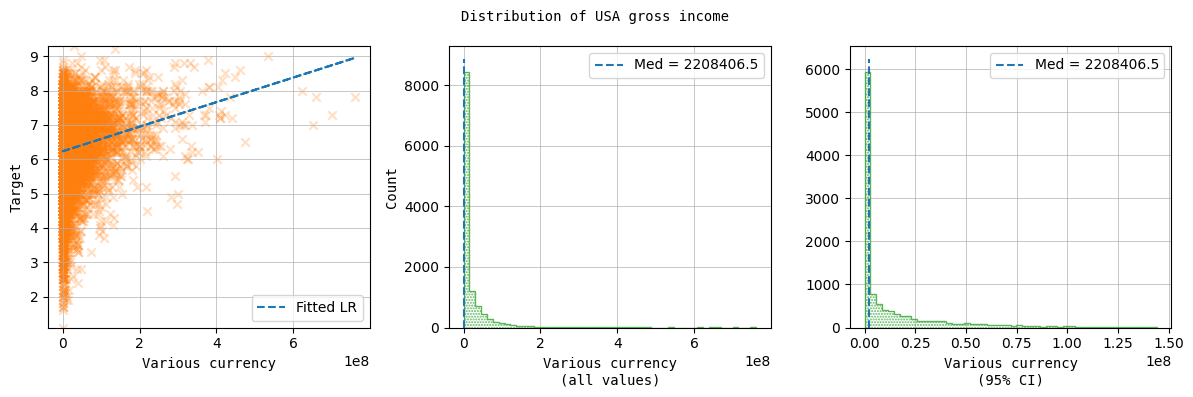

In [66]:
print(f"Pearson corr coef with target = {full_dataset['usa_gross_income_value'].corr(full_dataset[target]):.2f}")
describe(full_dataset['usa_gross_income_value'], 'num')
plot_hist(full_dataset.dropna(subset='usa_gross_income')['usa_gross_income_value'].values, full_dataset.dropna(subset='usa_gross_income')[target].values, 50, 95, 'Various currency', 'Distribution of USA gross income')

`usa_gross_income_value` looks like a continuous variable with expected heavy right tails (there are always box office blockbusters). It is rather loosely correlated with target. We will use it along with `usa_gross_income_currency` in our model.

In [67]:
# 15. Worldwide gross income and its currency and value components
describe(full_dataset['worlwide_gross_income'], 'cat')

18,920 unique
41,062 nulls
--------------------
worlwide_gross_income
$ 8144         16
$ 509          10
$ 46808        10
$ 97182         6
$ 2874          5
               ..
$ 1196218       1
$ 147080413     1
$ 3203          1
$ 3697          1
$ 7930          1
Name: count


In [68]:
full_dataset['worlwide_gross_income_currency'] = full_dataset['worlwide_gross_income'].str.split('\s', expand=True)[0]
full_dataset['worlwide_gross_income_value'] = full_dataset['worlwide_gross_income'].str.split('\s', expand=True)[1].astype(float)
# Fill null values with a constant value `Unknown`
full_dataset['worlwide_gross_income_currency'].fillna('Unknown', inplace=True)

In [69]:
describe(full_dataset['worlwide_gross_income_currency'], 'cat')

3 unique
0 nulls
--------------------
worlwide_gross_income_currency
Unknown    41062
$          19115
INR           21
Name: count


In [70]:
observed_df = pd.DataFrame(crosstab(full_dataset['worlwide_gross_income_currency'], full_dataset['avg_vote_bucket']).count)
df_index = full_dataset['worlwide_gross_income_currency'].value_counts().index.sort_values()
df_columns = full_dataset['avg_vote_bucket'].value_counts().index.sort_values()
observed_df.index = df_index
observed_df.columns = df_columns
observed_df

avg_vote_bucket,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10
worlwide_gross_income_currency,,,,,,,,,,
$,0,43,190,595,1729,4979,7708,3511,358,2
INR,0,0,0,0,1,1,5,7,7,0
Unknown,3,207,1008,2595,5210,9784,15835,5937,470,13


In [71]:
chi2_test_result = chi2_contingency(observed_df.values)
print(f'{chi2_test_result.pvalue = } (assuming significance level = 0.05)')

chi2_test_result.pvalue = 2.644952052197826e-190 (assuming significance level = 0.05)


Pearson corr coef with target = 0.15
41,062 nulls
Min = 1.00
Max = 2,789,968,301.00
Med = 1,506,883.50


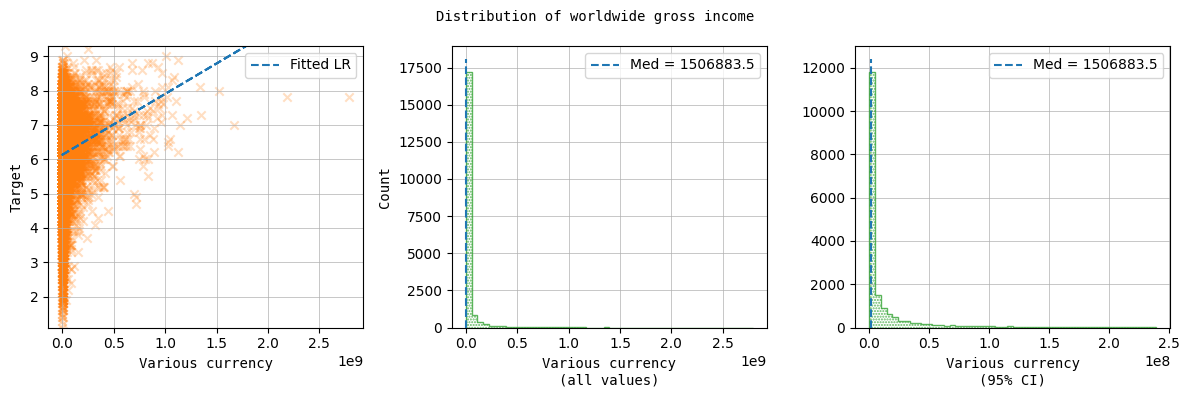

In [72]:
print(f"Pearson corr coef with target = {full_dataset['worlwide_gross_income_value'].corr(full_dataset[target]):.2f}")
describe(full_dataset['worlwide_gross_income_value'], 'num')
plot_hist(full_dataset.dropna(subset='worlwide_gross_income')['worlwide_gross_income_value'].values, full_dataset.dropna(subset='worlwide_gross_income')[target].values, 50, 95, 'Various currency', 'Distribution of worldwide gross income')

`worlwide_gross_income_value` looks like a continuous variable with expected heavy right tails (there are always box office blockbusters). It is rather loosely correlated with target. We will use it along with `worlwide_gross_income_currency` in our model.

Pearson corr coef with target = 0.72
51,386 nulls
Min = 1.00
Max = 100.00
Med = 56.00


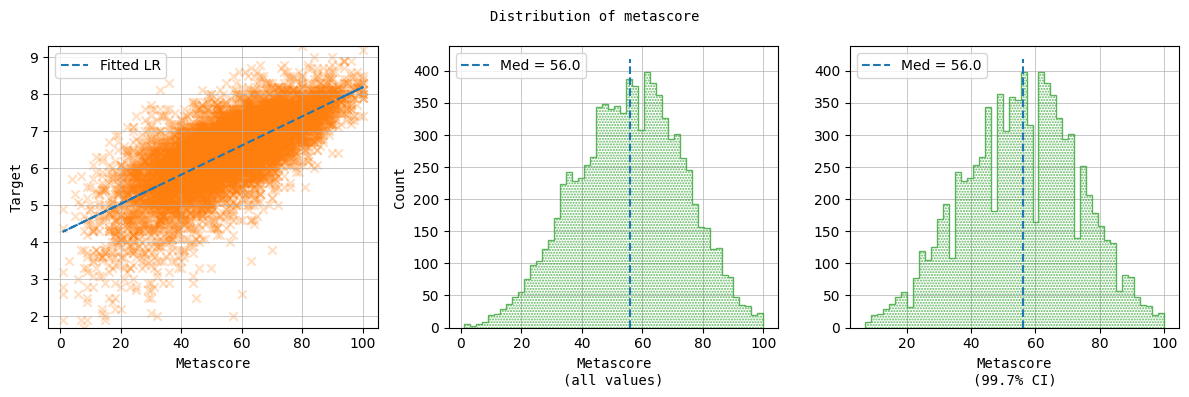

In [73]:
# 16. Metascore
print(f"Pearson corr coef with target = {full_dataset['metascore'].corr(full_dataset[target]):.2f}")
describe(full_dataset['metascore'], 'num')
plot_hist(full_dataset.dropna(subset='metascore')['metascore'].values, full_dataset.dropna(subset='metascore')[target].values, 50, 99.7, 'Metascore', 'Distribution of metascore')

`metascore` looks like a continuous variable with close to normal distribution. It is rather strongly correlated with target. Hopefully, this is not target leakage. We will use it in our model.

Pearson corr coef with target = 0.15
4,069 nulls
Min = 1.00
Max = 7,029.00
Med = 10.00


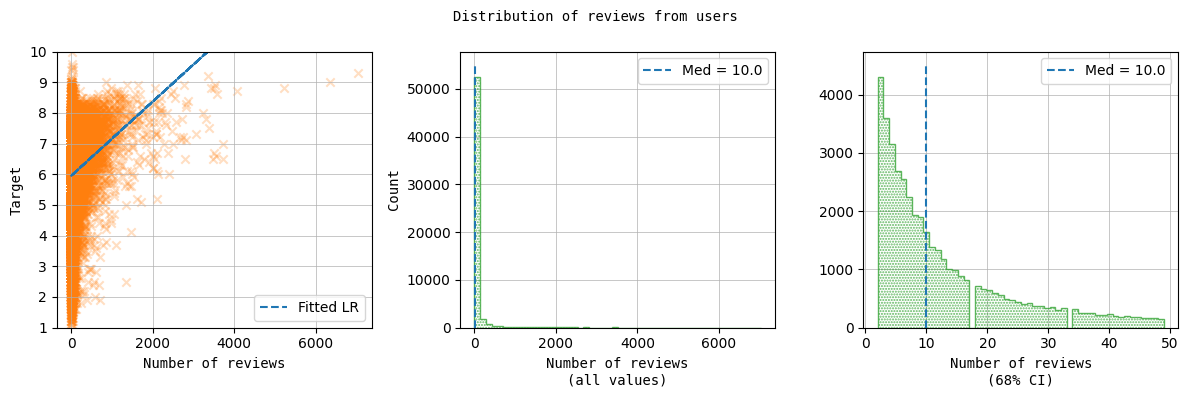

In [74]:
# 17. Reviews from users
print(f"Pearson corr coef with target = {full_dataset['reviews_from_users'].corr(full_dataset[target]):.2f}")
describe(full_dataset['reviews_from_users'], 'num')
plot_hist(full_dataset.dropna(subset='reviews_from_users')['reviews_from_users'].values, full_dataset.dropna(subset='reviews_from_users')[target].values, 50, 68, 'Number of reviews', 'Distribution of reviews from users')

`reviews_from_users` looks like a continuous variable with expected heavy right tails (there are always movies with large number of reviews). It is rather loosely correlated with target. We will use it in our model.

Pearson corr coef with target = 0.20
8,229 nulls
Min = 1.00
Max = 837.00
Med = 8.00


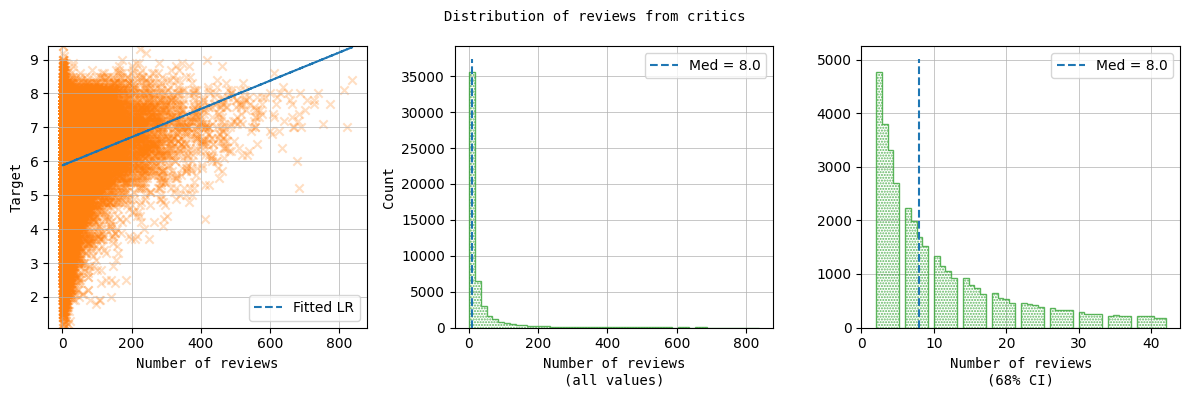

In [75]:
# 18. Reviews from critics
print(f"Pearson corr coef with target = {full_dataset['reviews_from_critics'].corr(full_dataset[target]):.2f}")
describe(full_dataset['reviews_from_critics'], 'num')
plot_hist(full_dataset.dropna(subset='reviews_from_critics')['reviews_from_critics'].values, full_dataset.dropna(subset='reviews_from_critics')[target].values, 50, 68, 'Number of reviews', 'Distribution of reviews from critics')

`reviews_from_critics` looks like a continuous variable with expected heavy right tails (there are always movies with large number of reviews). It is rather loosely correlated with target. We will use it in our model.

3.2. Final feature selection and transformation

Now that we have agreed on the set of features, we need to transform them. For that, we'll define column transformer that will take care of it and will be used in the future models' pipelines.

Observe, that categorical variables, such as `director`, have many unique value, which will result in introducing many new binary features, if using one hot encoding for their transformation. This will create a too complex model with thousands of parameters. Though the bias is expected to be low, the variance of such model is expected to be very high. This means that the model will not be able to generalize and thus will be useless in practice. For that reason, we will _not_ use one hot encoding.

For linear models, we need to make sure that features (and thus weights) are neither too small, nor too large. The best way to do it is to either scale them or encode them with mean target encoder.

This is not a problem for models based on decision trees. So, we can use either ordinal or mean target encoding, and scaling is possible, but not necessary.

In [76]:
ord_cols = ['year', 
            'date_published_year']

num_cols = ['duration', 
            'votes', 
            'usa_gross_income_value', 
            'worlwide_gross_income_value', 
            'metascore', 
            'reviews_from_users', 
            'reviews_from_critics']

cat_cols = ['genre', 
            'country', 
            'language', 
            'director', 
            'writer', 
            'production_company', 
            'actors', 
            'usa_gross_income_currency', 
            'worlwide_gross_income_currency']

oe_pipe = make_pipeline(OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
real_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
mte_pipe = make_pipeline(TargetEncoder(target_type='continuous', random_state=seed))

column_transformer_lr = ColumnTransformer([('ord_cols', oe_pipe, ord_cols),
                                        ('num_cols', mte_pipe, num_cols), 
                                        ('cat_cols', mte_pipe, cat_cols)], n_jobs=-1)

column_transformer_dt = ColumnTransformer([('ord_cols', oe_pipe, ord_cols),
                                        ('num_cols', real_pipe, num_cols), 
                                        ('cat_cols', mte_pipe, cat_cols)], n_jobs=-1)

Final features set:

|  n | Feature                          | Type |
|---:|----------------------------------|------|
|  1 | `year`                           | Ord  |
|  2 | `date_published_year`            | Ord  |
|  3 | `duration`                       | Num  |
|  4 | `votes`                          | Num  |
|  5 | `usa_gross_income_value`         | Num  |
|  6 | `worlwide_gross_income_value`    | Num  |
|  7 | `metascore`                      | Num  |
|  8 | `reviews_from_users`             | Num  |
|  9 | `reviews_from_critics`           | Num  |
| 10 | `genre`                          | Cat  |
| 11 | `country`                        | Cat  |
| 12 | `language`                       | Cat  |
| 13 | `director`                       | Cat  |
| 14 | `writer`                         | Cat  |
| 15 | `production_company`             | Cat  |
| 16 | `actors`                         | Cat  |
| 17 | `usa_gross_income_currency`      | Cat  |
| 18 | `worlwide_gross_income_currency` | Cat  |

3.3. Split data into train and test


In [77]:
tr, te = train_test_split(full_dataset[ord_cols + num_cols + cat_cols + [target]], test_size=0.2, random_state=seed)

In [78]:
print(tr.shape)
tr.head(5)

(48158, 19)


,year,date_published_year,duration,votes,usa_gross_income_value,worlwide_gross_income_value,metascore,reviews_from_users,reviews_from_critics,genre,country,language,director,writer,production_company,actors,usa_gross_income_currency,worlwide_gross_income_currency,avg_vote
27388,1994,1995,133,136762,66638883.0,160638883.0,45.0,375.0,63.0,Drama,USA,English,Edward Zwick,Susan Shilliday,TriStar Pictures,Brad Pitt,$,$,7.5
27082,1994,1994,107,3323,NaN,NaN,NaN,9.0,2.0,Comedy,Italy,English,Terence Hill,Jess Hill,Rialto Film,Terence Hill,Unknown,Unknown,6.1
15645,1973,1973,131,653,NaN,NaN,NaN,10.0,1.0,Drama,India,Hindi,Sudhendu Roy,Narendranath Mitra,Rajshri Productions,Amitabh Bachchan,Unknown,Unknown,7.2
43207,2005,2005,121,50090,32116746.0,76932872.0,35.0,393.0,149.0,Action,USA,English,Rob Cohen,W.D. Richter,Columbia Pictures,Josh Lucas,$,$,5.1
50700,2010,2010,105,184462,26593646.0,44093316.0,60.0,398.0,402.0,Action,USA,English,Ethan Maniquis,Robert Rodriguez,Overnight Films,Danny Trejo,$,$,6.6


In [79]:
print(te.shape)
te.head(5)

(12040, 19)


,year,date_published_year,duration,votes,usa_gross_income_value,worlwide_gross_income_value,metascore,reviews_from_users,reviews_from_critics,genre,country,language,director,writer,production_company,actors,usa_gross_income_currency,worlwide_gross_income_currency,avg_vote
30718,1995,1995,98,326,NaN,NaN,NaN,7.0,4.0,Drama,USA,English,Craig Singer,Craig Singer,Vanguard International Cinema,Ryan Payne Bell,Unknown,Unknown,5.2
60049,2012,2013,99,1501,11157.0,12155.0,57.0,14.0,36.0,Drama,USA,English,Daniel Algrant,Daniel Algrant,Archer Gray,Imogen Poots,$,$,6.1
470,1926,1926,112,3753,NaN,NaN,NaN,38.0,28.0,Drama,USA,Unknown,Clarence Brown,Benjamin Glazer,Metro-Goldwyn-Mayer (MGM),John Gilbert,Unknown,Unknown,7.7
588,1927,1927,63,6657,NaN,4841.0,NaN,107.0,50.0,Drama,USA,English,Tod Browning,Tod Browning,Metro-Goldwyn-Mayer (MGM),Lon Chaney,Unknown,$,7.8
28554,1996,1996,89,639,NaN,NaN,NaN,6.0,9.0,Comedy,Tunisia,French,Férid Boughedir,Férid Boughedir,Canal+,Sonia Mankaï,Unknown,Unknown,6.5


In [80]:
y_train = tr['avg_vote']
y_test = te['avg_vote']
X_train = tr.drop(['avg_vote'], axis=1)
X_test = te.drop(['avg_vote'], axis=1)

---
##### <a id="model"></a>4. Modeling

Train and compare the models

4.1. Select models, you are going to train, select hyperparameters that have to be tuned.

Let's consider 6 models to fit our data for the regression problem:
- Linear Regression (baseline model)
- Lasso (linear regression with $L_1$ regularization)
- Ridge (linear regression with $L_2$ regularization)
- Decision Tree
- Random Forest
- Gradient Boosting (for decision trees)

In [81]:
models_to_eval = [{'name': 'LR', 'model': LinearRegression(n_jobs=-1), 'transformer': column_transformer_lr, 'mean_score': 0.0},
                  {'name': 'Lasso', 'model': Lasso(random_state=seed), 'transformer': column_transformer_lr, 'mean_score': 0.0},
                  {'name': 'Ridge', 'model': Ridge(random_state=seed), 'transformer': column_transformer_lr, 'mean_score': 0.0},
                  {'name': 'DT', 'model': DecisionTreeRegressor(random_state=seed), 'transformer': column_transformer_dt, 'mean_score': 0.0},
                  {'name': 'RF', 'model': RandomForestRegressor(n_jobs=-1, random_state=seed), 'transformer': column_transformer_dt, 'mean_score': 0.0},
                  {'name': 'GB', 'model': GradientBoostingRegressor(random_state=seed), 'transformer': column_transformer_dt, 'mean_score': 0.0},
                  ]

First let's see the models' performance with default hyperparameters (out of the box). For that, we will use 5-fold cross-validation on train data. This will be a good indication of models' performance on test data.

In [82]:
print('Mean scores (out of the box)')
for model_to_eval in models_to_eval:
    pipe = make_pipeline(model_to_eval['transformer'], model_to_eval['model'])
    pipe.fit(X_train, y_train)
    model_to_eval['mean_score'] = np.abs(cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2', n_jobs=-1).mean())
    print(f"{model_to_eval['name']:<5}: {model_to_eval['mean_score']:.2f}")

Mean scores (out of the box)
LR   : 0.50
Lasso: 0.05
Ridge: 0.50
DT   : 0.13
RF   : 0.58
GB   : 0.57


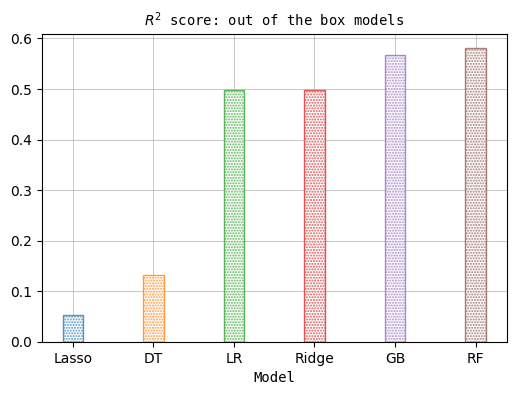

In [83]:
plot_bar(pd.DataFrame(models_to_eval).sort_values(by='mean_score'), 'name', 'mean_score', 'Model', '$R^2$ score: out of the box models')

Since most of the numerical features are only loosely linearly correlated with the target, it is rather expected that linear models are not as good. At the same time, as expected, ensemble models based on decision trees perform better.

Next, we will try to tune hyperparameters to optimize $R^2$ scores and then choose the best estimator with the best mean score. We will tune the following hyperparameters:
- Linear regression:
    - this model does not have hyperparameters
- Lasso:
    - $\lambda$ (coefficient of regularization). If $\lambda = 0$, then no regularization and it is basically linear regression model.
- Ridge:
    - $\lambda$ (coefficient of regularization). If $\lambda = 0$, then no regularization and it is basically linear regression model.
- Decision Tree:
    - maximal depth of the tree. If maximal depth is not set, then nodes are split until all leaves are pure, which may cause high variance and thus overfitting
- Random Forest:
    - number of trees in the forest
    - maximal depth of each tree. If maximal depth is not set, then nodes are split until all leaves are pure, which may cause high variance and thus overfitting for a given tree, but since it is an ensemble, the total variance should decrease proportionally to the number of trees in the forest
- Gradient Boosting:
    - number of trees in ensemble
    - maximal depth of each tree. If maximal depth is not set, then nodes are split until all leaves are pure. Usually the trees are shallow (not deep).

4.2. Use cross-validation to compare models and select best set of hyperparameters

In [84]:
param_grid = [
    {
        'column_transformer': [column_transformer_lr],
        'estimator': [LinearRegression(n_jobs=-1)]
        # No hyperparameters
    },
    {
        'column_transformer': [column_transformer_lr],
        'estimator': [Lasso(random_state=seed)],
        'estimator__alpha': [0.01, 0.1, 1.0, 5.0, 10.0]
    },
    {
        'column_transformer': [column_transformer_lr],
        'estimator': [Ridge(random_state=seed)],
        'estimator__alpha': [0.01, 0.1, 1.0, 5.0, 10.0]
    },
    {
        'column_transformer': [column_transformer_dt],
        'estimator': [DecisionTreeRegressor(random_state=seed)],
        'estimator__max_depth': [10, 20, 50]
    },
    {
        'column_transformer': [column_transformer_dt],
        'estimator': [RandomForestRegressor(n_jobs=-1, random_state=seed)],
        'estimator__n_estimators': [100, 200, 300],
        'estimator__max_depth': [10, 20, 50]
    },
    {
        'column_transformer': [column_transformer_dt],
        'estimator': [GradientBoostingRegressor(random_state=seed)],
        'estimator__n_estimators': [100, 200, 300],
        'estimator__max_depth': [3, 5, 7, 9]
    }
]

In [85]:
model_best = Pipeline([('column_transformer', None), ('estimator', None)])
grid_pipe = GridSearchCV(estimator=model_best, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_pipe.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer', None),
                                       ('estimator', None)]),
             n_jobs=-1,
             param_grid=[{'column_transformer': [ColumnTransformer(n_jobs=-1,
                                                                   transformers=[('ord_cols',
                                                                                  Pipeline(steps=[('ordinalencoder',
                                                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                  unknown_value=-1))]),
                                                                                  ['year',
                                                                                   'date_published_year']),
                                                                                 ('num_cols',
                                                                                  Pipeline(...
                                                                                                   TargetEncoder(random_state=0,
                                                                                                                 target_type='continuous'))]),
                                                                                  ['genre',
                                                                                   'country',
                                                                                   'language',
                                                                                   'director',
                                                                                   'writer',
                                                                                   'production_company',
                                                                                   'actors',
                                                                                   'usa_gross_income_currency',
                                                                                   'worlwide_gross_income_currency'])])],
                          'estimator': [GradientBoostingRegressor(max_depth=7,
                                                                  n_estimators=200,
                                                                  random_state=0)],
                          'estimator__max_depth': [3, 5, 7, 9],
                          'estimator__n_estimators': [100, 200, 300]}],
             scoring='r2')

In [86]:
# Overall best estimator
best_estimator = grid_pipe.best_estimator_
print(f'Best estimator:  {best_estimator.steps[1][1]}')
print(f'Best mean score: {grid_pipe.best_score_:.2f}')

Best estimator:  GradientBoostingRegressor(max_depth=7, n_estimators=200, random_state=0)
Best mean score: 0.60


In [87]:
cv_results_df = pd.DataFrame(grid_pipe.cv_results_)
# Extract the estimators' names
cv_results_df['model'] = cv_results_df['param_estimator'].apply(lambda x: x.__str__()).str.split('(', expand=True)[0] \
                            .str.replace('LinearRegression', 'LR') \
                            .str.replace('DecisionTreeRegressor', 'DT') \
                            .str.replace('RandomForestRegressor', 'RF') \
                            .str.replace('GradientBoostingRegressor', 'GB')

In [88]:
print('Mean scores (optimized)')
best_scores = cv_results_df.groupby('model')['mean_test_score'].max()
print(best_scores.to_string(float_format=lambda x: f'{x:.2f}', header=False, name=False))

Mean scores (optimized)
DT      0.47
GB      0.60
LR      0.50
Lasso   0.49
RF      0.58
Ridge   0.50


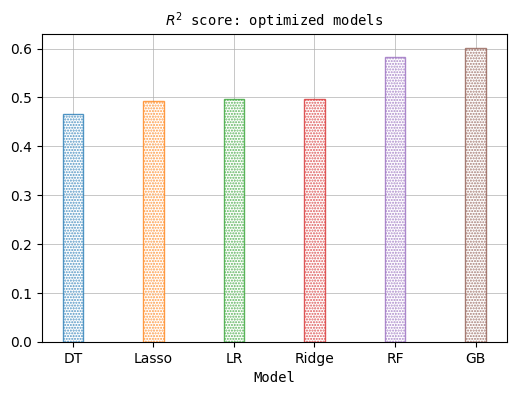

In [89]:
plot_bar(pd.DataFrame(best_scores).reset_index().sort_values(by='mean_test_score'), 'model', 'mean_test_score', 'Model', '$R^2$ score: optimized models')

4.3 Which model and setup is the best? How does it perform on the test dataset? If you were to present this model to the client, how would you describe it?

After hyperparameters optimization, __the best model is `Gradient Boosting`__ with 200 trees of depth 7. __The mean $R^2_{CV} \approx $ 0.60__ for 5-fold cross-validation on train data, which is an increase from 0.57 without hyperparameters optimization.

Let's also take a look at the grid search space for Gradient Boosting estimators family.

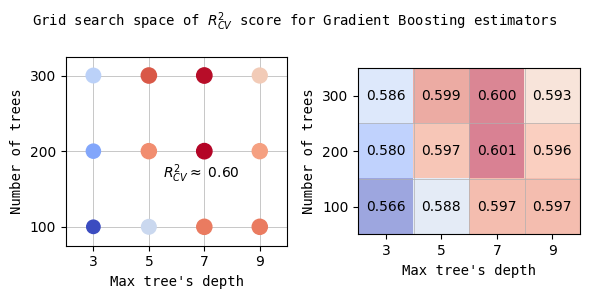

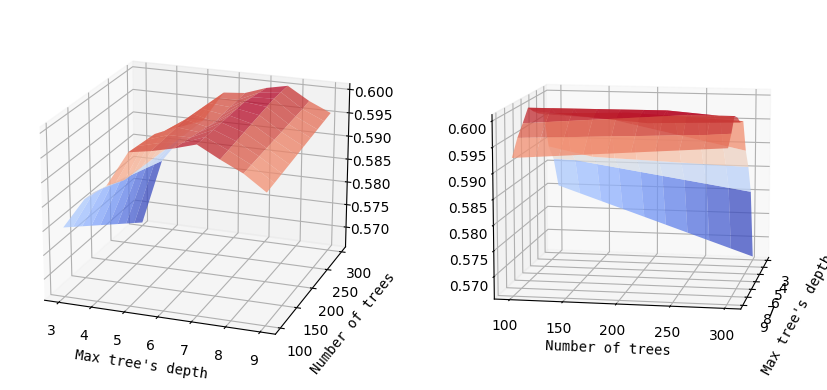

In [90]:
grid_gb = cv_results_df[cv_results_df['model'] == 'GB'].copy()
grid_gb['param_estimator__max_depth'].fillna(0, inplace=True)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.scatter(grid_gb['param_estimator__max_depth'], grid_gb['param_estimator__n_estimators'], s=np.exp(8 * grid_gb['mean_test_score']), c=np.exp(50 * grid_gb['mean_test_score']), cmap='coolwarm')
plt.text(grid_gb[grid_gb['rank_test_score'] == 1]['param_estimator__max_depth'].values[0] - 1.5, grid_gb[grid_gb['rank_test_score'] == 1]['param_estimator__n_estimators'].values[0] - 35, f"$R^2_{{CV}} \\approx$ {grid_gb[grid_gb['rank_test_score'] == 1]['mean_test_score'].values[0]:.2f}")
plt.xticks([3, 5, 7, 9], [3, 5, 7, 9])
plt.yticks([100, 200, 300])
plt.xlim([2, 10])
plt.ylim([75, 325])
plt.xlabel("Max tree's depth", size=10, family='monospace')
plt.ylabel('Number of trees', size=10, family='monospace')
plt.gca().set_axisbelow(True)
plt.grid(lw=0.5)
plt.subplot(1, 2, 2)
plt.imshow(np.exp(50 * grid_gb['mean_test_score']).values.reshape(4, 3).T[::-1], cmap='coolwarm', alpha=0.5)
for (j, i), label in np.ndenumerate(grid_gb['mean_test_score'].values.reshape(4, 3).T[::-1]):
    plt.text(i, j, f'{label:.3f}', ha='center', va='center')
plt.xticks(range(4), [3, 5, 7, 9])
plt.yticks(range(3), [300, 200, 100])
plt.xlabel("Max tree's depth", size=10, family='monospace')
plt.ylabel('Number of trees', size=10, family='monospace')
plt.xticks(np.arange(4) + 0.5, minor=True) # Turn on minor ticks only for plotting the grid
plt.yticks(np.arange(3) + 0.5, minor=True)
plt.grid(which='minor', lw=0.5)
plt.tick_params(which='minor', bottom=False, left=False); # Turn off minor ticks after plotting the grid
plt.suptitle('Grid search space of $R^2_{CV}$ score for Gradient Boosting estimators', size=10, family='monospace')
plt.tight_layout();

fig = plt.figure(figsize=(9, 4))
ax3d = fig.add_subplot(121, projection='3d')
XX, YY = np.meshgrid(np.linspace(3, 9, 10), np.linspace(100, 300, 10))
Z = interpolate.interp1d(grid_gb['mean_test_score'].index, grid_gb['mean_test_score'].values)(np.linspace(grid_gb['mean_test_score'].index.min(), grid_gb['mean_test_score'].index.max(), 100)).reshape(10, 10).T[::-1]
ax3d.plot_surface(XX, YY, Z, cmap='coolwarm', alpha=0.75)
ax3d.view_init(20, -70, 0)
ax3d.set_xlabel("Max tree's depth", size=10, family='monospace')
ax3d.set_ylabel('Number of trees', size=10, family='monospace')
ax3d.set_zlim(Z.min(), Z.max())
ax3d = fig.add_subplot(122, projection='3d')
XX, YY = np.meshgrid(np.linspace(3, 9, 10), np.linspace(100, 300, 10))
Z = interpolate.interp1d(grid_gb['mean_test_score'].index, grid_gb['mean_test_score'].values)(np.linspace(grid_gb['mean_test_score'].index.min(), grid_gb['mean_test_score'].index.max(), 100)).reshape(10, 10).T[::-1]
ax3d.plot_surface(XX, YY, Z, cmap='coolwarm', alpha=0.75)
ax3d.view_init(10, 10, 0)
ax3d.set_xlabel("Max tree's depth", size=10, family='monospace')
ax3d.set_ylabel('Number of trees', size=10, family='monospace')
ax3d.set_zlim(Z.min(), Z.max())
plt.tight_layout();

We can see, that $R^2_{CV}$ depends more on the max tree's depth than on the number of trees in the ensemble.

Now, let's calculate the __best estimator's $R^2$ score for the `train` and for the `unseen test` data__.

In [91]:
print(f'r2_train = {best_estimator.score(X_train, y_train):.2f}')
print(f'r2_test  = {best_estimator.score(X_test, y_test):.2f}')

r2_train = 0.84
r2_test  = 0.62


As expected, $R^2_{test}$ score is of the same order as obtained during the 5-fold cross-validation on the train data. At the same time, $R^2_{train}$ score for the train data is larger, which means that the model is overfitting.

---
##### <a id="interp"></a>5. Model Interpretation

5.1. Feature importances

Let's look at what features are the most valuable predictors. For models based on decision trees, feature importance is evaluated as the normalized total reduction of the criterion brought by that feature. By default for regression trees, squared error is used as the criterion to measure the quality of a split. The higher the reduction, i.e. the more impurity the feature eliminates or in other words, it influences on the decision boundary, the more important the feature is.

In [92]:
feature_importances_df = pd.DataFrame([best_estimator.feature_names_in_, best_estimator.steps[1][1].feature_importances_]).T \
                        .rename(columns={0: 'feature', 1: 'importance'}) \
                        .sort_values(by='importance', ascending=False) \
                        .reset_index(drop=True)
feature_importances_df.style\
    .highlight_quantile(subset='importance', q_left=0.8, color='lightgreen')\
    .set_caption('<h4>Feature importances (green = top 20%)</h4>')

,feature,importance
0,director,0.357343
1,votes,0.097620
2,genre,0.084514
3,production_company,0.075799
4,language,0.061905
5,actors,0.057037
6,metascore,0.042962
7,year,0.042237
8,duration,0.037769
9,writer,0.033539


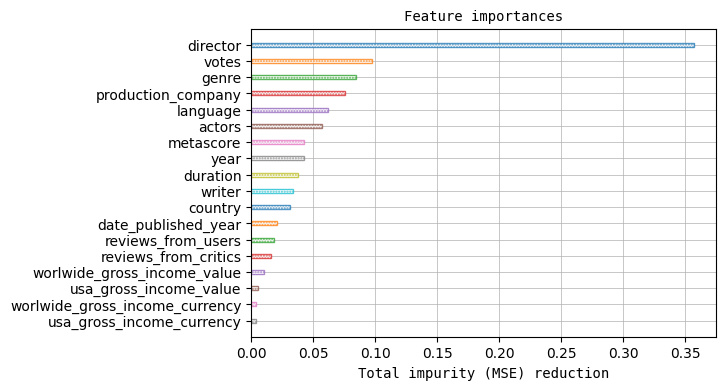

In [93]:
plot_bar(feature_importances_df, 'feature', 'importance', 'Total impurity (MSE) reduction', 'Feature importances', 'horizontal')

So, according to our model, __`director` is the top predictor__ that influences the success of the movie. Well, it's not a big surprise: successful movies are directed by talented directors.

Now let's see the weights of our best baseline Linear regression model, obtained during grid search above. The model weights may be considered as sort of feature importances.

In [94]:
best_lr = cv_results_df.iloc[cv_results_df[cv_results_df['model'] == 'LR']['mean_test_score'].idxmax()]
best_lr_pipe = make_pipeline(best_lr['param_column_transformer'], best_lr['param_estimator'])
best_lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('ord_cols',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['year',
                                                   'date_published_year']),
                                                 ('num_cols',
                                                  Pipeline(steps=[('targetencoder',
                                                                   TargetEncoder(random_state=0,
                                                                                 target_type='continuous'))]),
                                                  ['duration', 'votes'...
                                                   'metascore',
                                                   'reviews_from_users',
                                                   'reviews_from_critics']),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('targetencoder',
                                                                   TargetEncoder(random_state=0,
                                                                                 target_type='continuous'))]),
                                                  ['genre', 'country',
                                                   'language', 'director',
                                                   'writer',
                                                   'production_company',
                                                   'actors',
                                                   'usa_gross_income_currency',
                                                   'worlwide_gross_income_currency'])])),
                ('linearregression', LinearRegression(n_jobs=-1))])

In [95]:
pd.DataFrame([best_lr_pipe.feature_names_in_, best_lr_pipe.steps[1][1].coef_]).T \
    .rename(columns={0: 'feature', 1: 'weight'}) \
    .sort_values(by='weight', ascending=False) \
    .reset_index(drop=True) \
    .style \
    .highlight_quantile(subset='weight', q_left=0.8, color='lightgreen')\
    .set_caption('<h4>Feature weights (green = top 20%)</h4>')

,feature,weight
0,language,0.567827
1,metascore,0.515691
2,genre,0.514390
3,worlwide_gross_income_currency,0.430440
4,reviews_from_critics,0.352900
5,duration,0.349972
6,director,0.266948
7,usa_gross_income_currency,0.263524
8,actors,0.220731
9,production_company,0.189412


The model suggests `language` as the top predictor. Well, probably this is not a good criterion to measure the movie success. And if language is not a good criterion indeed, it is quite expected that the linear regression model is a weaker estimator than the gradient boosting model is.

Let's also extract the top nodes of the decision tree. Gradient Boosting is an ensemble model, so it is not obvious how to "re-build" a single decision tree. Instead, we'll fit the best DecisionTreeRegressor model, which was obtained during grid search above, and look at its tree.

In [96]:
best_dt = cv_results_df.iloc[cv_results_df[cv_results_df['model'] == 'DT']['mean_test_score'].idxmax()]
best_dt_pipe = make_pipeline(best_dt['param_column_transformer'], best_dt['param_estimator'])
best_dt_pipe.fit(X_train, y_train)
print(tree.export_text(best_dt_pipe.steps[1][1], feature_names=list(best_dt_pipe.feature_names_in_), max_depth=2))

|--- director <= 6.00
|   |--- production_company <= 6.00
|   |   |--- genre <= 5.93
|   |   |   |--- truncated branch of depth 43
|   |   |--- genre >  5.93
|   |   |   |--- truncated branch of depth 41
|   |--- production_company >  6.00
|   |   |--- language <= 6.33
|   |   |   |--- truncated branch of depth 35
|   |   |--- language >  6.33
|   |   |   |--- truncated branch of depth 27
|--- director >  6.00
|   |--- director <= 6.80
|   |   |--- votes <= -0.17
|   |   |   |--- truncated branch of depth 42
|   |   |--- votes >  -0.17
|   |   |   |--- truncated branch of depth 31
|   |--- director >  6.80
|   |   |--- votes <= -0.17
|   |   |   |--- truncated branch of depth 34
|   |   |--- votes >  -0.17
|   |   |   |--- truncated branch of depth 30



As expected, `director` is still the most important feature. `genre` and `production_company` are the other top predictors. Though `votes` is among the top predictors too, we will not consider it, since we do not know for sure, if it is a target leaker or not. Let's list top 10-20 values of each of these 3 most important predictors, sorted by their encoded values.

Observe, that the split for `director` was made at 6.00; for `genre` at 5.93; and for `production company` at 6.00. We'll use these thresholds for examining the original predictors values. i.e. text values. Note, that since we used TargetEncoder for categorical features, the encoded values are of the same order as the target `avg_vote`.

In [97]:
# Fit-transform feature matrix for train data and convert it into Pandas dataframe
col_names_trans = [f'{_}_transformed' for _ in X_train.columns]
transformed_pipe = Pipeline([('column_transformer', column_transformer_dt), ('pandarizer', FunctionTransformer(lambda x: pd.DataFrame(x, columns=col_names_trans)))]).fit_transform(X_train, y_train)
transformed_pipe.head()

,year_transformed,date_published_year_transformed,duration_transformed,votes_transformed,usa_gross_income_value_transformed,worlwide_gross_income_value_transformed,metascore_transformed,reviews_from_users_transformed,reviews_from_critics_transformed,genre_transformed,country_transformed,language_transformed,director_transformed,writer_transformed,production_company_transformed,actors_transformed,usa_gross_income_currency_transformed,worlwide_gross_income_currency_transformed
0,83.0,84.0,1.448086,2.311207,2.879420,2.947614,-1.599061,2.321479,0.747205,6.365407,5.708748,5.736340,6.918773,5.996473,6.056499,6.924734,6.298114,6.176189
1,83.0,83.0,0.316793,-0.127777,-0.166982,-0.150678,0.008787,-0.232266,-0.438042,5.983489,6.000412,5.735347,5.998271,5.998271,6.023908,6.580150,5.923358,5.912366
2,62.0,62.0,1.361063,-0.176579,-0.166982,-0.150678,0.008787,-0.225289,-0.457472,6.355519,6.299778,5.957875,5.998271,5.998271,6.953370,6.091675,5.923358,5.912366
3,94.0,94.0,0.925951,0.727025,1.246624,1.317788,-3.060740,2.447073,2.418209,5.627461,5.713056,5.735076,5.888883,6.326225,6.378462,5.890774,6.292494,6.173432
4,99.0,99.0,0.229771,3.183063,0.985397,0.678375,0.593459,2.481961,7.334071,5.645307,5.713192,5.736035,5.996047,5.445228,5.996047,3.856083,6.299958,6.183178


In [98]:
# 1. Director
# Combine transformed features with original values
directors_df = pd.concat([X_train.reset_index(drop=True), transformed_pipe], axis=1).groupby('director')
# List and sort top 20 directors
# Also, we want directors with some reputation, say, who directed at least 5 movies in their career
threshold = 6.0
directors_df['director_transformed'].mean()[(directors_df['director_transformed'].mean() > threshold) & (directors_df['director_transformed'].count() >= 5)].sort_values(ascending=False).head(20)

director
Christopher Nolan       8.317465
Andrei Tarkovsky        8.037495
Satyajit Ray            8.004862
Nikolai Volev           7.994320
Hayao Miyazaki          7.985116
Tapan Sinha             7.874779
Sergio Leone            7.854798
Edward Yang             7.785079
Krzysztof Kieslowski    7.758927
Charles Chaplin         7.758682
Stanley Kubrick         7.750880
Yavuz Turgul            7.697094
Sergei M. Eisenstein    7.687227
Ertem Egilmez           7.673302
Tengiz Abuladze         7.661712
Quentin Tarantino       7.656471
Emir Kusturica          7.650393
Yorgos Tzavellas        7.648662
Mani Ratnam             7.645156
Robert Bresson          7.643878
Name: director_transformed, dtype: float64

We can clearly see some of the top world-renowned directors of all times.

In [99]:
# 2. Genre
# Combine transformed features with original values
genres_df = pd.concat([X_train.reset_index(drop=True), transformed_pipe], axis=1).groupby('genre')
# List and sort top 10 genres
# Also, we want genres with some reputation, say, which have at least 100 movies in their category
threshold = 5.93
genres_df['genre_transformed'].mean()[(genres_df['genre_transformed'].mean() > threshold) & (genres_df['genre_transformed'].count() >= 100)].sort_values(ascending=False).head(10)

genre
Biography    6.682033
Animation    6.447152
Drama        6.360751
Crime        6.220745
Musical      6.146540
Comedy       5.978720
Romance      5.970800
Western      5.942608
Name: genre_transformed, dtype: float64

No surprise, Drama, Crime, Comedy, and Animation are among the genres that bring success. Interestingly, Biography is the leader.

In [100]:
# 3. Production company
# Combine transformed features with original values
production_companies_df = pd.concat([X_train.reset_index(drop=True), transformed_pipe], axis=1).groupby('production_company')
# List and sort top 20 production companies
# Also, we want production companies with some reputation, say, which produced at least 100 movies
threshold = 6.0
production_companies_df['production_company_transformed'].mean()[(production_companies_df['production_company_transformed'].mean() > threshold) & (production_companies_df['production_company_transformed'].count() >= 100)].sort_values(ascending=False).head(20)

production_company
Mosfilm                                  7.167194
Lenfilm Studio                           6.829540
Toho Company                             6.668577
Shaw Brothers                            6.599750
Walt Disney Productions                  6.583901
Twentieth Century Fox                    6.501039
Universal International Pictures (UI)    6.496757
Paramount Pictures                       6.492411
Warner Bros.                             6.464592
Metro-Goldwyn-Mayer (MGM)                6.431691
Universal Pictures                       6.411017
Columbia Pictures                        6.397310
CJ Entertainment                         6.377703
Touchstone Pictures                      6.358925
First National Pictures                  6.315439
RKO Radio Pictures                       6.302226
Republic Pictures (I)                    6.151935
Canal+                                   6.145603
Name: production_company_transformed, dtype: float64

Again, no surprise that the top world-renowned production companies are in the list.

5.2. Partial dependence plots (PDP)

Finally, let's look at partial dependences (PD) of the target from individual features. The idea is to predict the target for a number of fixed values for each feature (within its domain), i.e. to compute the target prediction as a function of some feature, keeping other (complementary) features intact. If the target prediction function responds to different values of a feature, then this feature is considered as important, otherwise not. These predictions are Individual Conditional Expectations (ICE) for each feature of interest. PD is simply the average of ICE for each feature of interest over all predictions (number of observations). The main advantage of this model interpretation method is that we do not make any assumptions about linear / non-linear dependencies of the target from the features -- we simply assess these dependences ad hoc from real model predictions.

Quick warnings:
- PD method has an assumption of feature independence between each other, but we did not check this assumption while doing feature engineering in section <a id="discuss">3</a> above.
- Not all values of features, especially categorical, make sense for all observations. For example, present day directors could not direct movies 50+ years ago, but we still compute predictions for such surrogate observations.

Given these warning, the results of PDP should be used with caution.

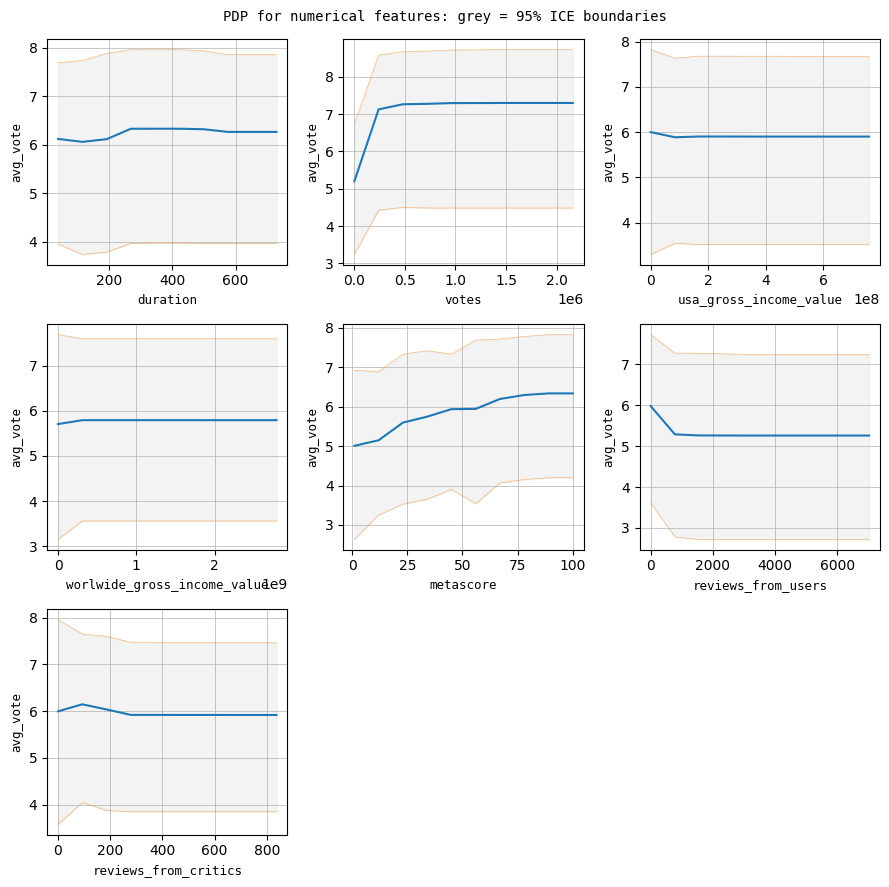

In [101]:
# Numerical features
conf_lvl = 95 # %
ncols = 3
nrows = int(np.ceil(len(num_cols) / ncols))
plt.figure(figsize=(ncols * 3, nrows * 3))
for i, feature_name in enumerate(num_cols, start=1):
    plt.subplot(nrows, ncols, i)
    pdp_df = predict_partial(X_train, feature_name, best_estimator, kind='num', grid_size=10, conf_lvl=conf_lvl)
    plt.plot(pdp_df['Value'], pdp_df['Pred_mean'], color='C0')
    # Show Individual Conditional Expectation (ICE) boundaries, as per `conf_lvl`
    plt.plot(pdp_df['Value'], pdp_df['ICE_hi'], color='C1', lw=0.5, alpha=0.5)
    plt.plot(pdp_df['Value'], pdp_df['ICE_lo'], color='C1', lw=0.5, alpha=0.5)
    plt.fill_between(pdp_df['Value'], pdp_df['ICE_hi'], pdp_df['ICE_lo'], color='lightgrey', alpha=0.25)
    plt.xlabel(feature_name, size=9, family='monospace')
    plt.ylabel(target, size=9, family='monospace')
    plt.suptitle(f'PDP for numerical features: grey = {conf_lvl}% ICE boundaries', size=10, family='monospace')
    plt.grid(lw=0.5)
plt.tight_layout();

Looks like, people do not like both very short and very long movies (`duration`). Target expectedly has positive dependence with `votes` and `metascore`. But we are still not sure, if they are target leakers or not. Also, interestingly, the target decreases as the number of `reviews_from_users` grows, so it looks like successful movies do not necessarily have many reviews.

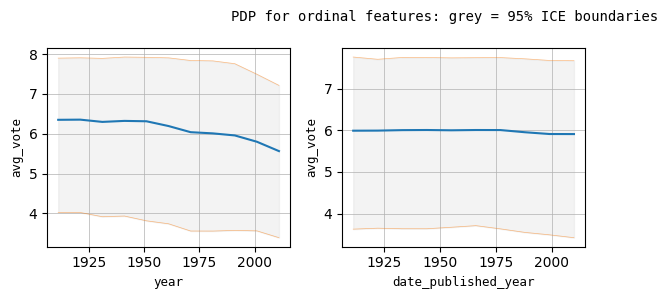

In [102]:
# Ordinal features
conf_lvl = 95 # %
ncols = 3
nrows = int(np.ceil(len(ord_cols) / ncols))
plt.figure(figsize=(ncols * 3, nrows * 3))
for i, feature_name in enumerate(ord_cols, start=1):
    plt.subplot(nrows, ncols, i)
    pdp_df = predict_partial(X_train, feature_name, best_estimator, kind='ord', grid_size=10, conf_lvl=conf_lvl)
    plt.plot(pdp_df['Value'], pdp_df['Pred_mean'], color='C0')
    # Show Individual Conditional Expectation (ICE) boundaries, as per `conf_lvl`
    plt.plot(pdp_df['Value'], pdp_df['ICE_hi'], color='C1', lw=0.5, alpha=0.5)
    plt.plot(pdp_df['Value'], pdp_df['ICE_lo'], color='C1', lw=0.5, alpha=0.5)
    plt.fill_between(pdp_df['Value'], pdp_df['ICE_hi'], pdp_df['ICE_lo'], color='lightgrey', alpha=0.25)
    plt.xlabel(feature_name, size=9, family='monospace')
    plt.ylabel(target, size=9, family='monospace')
    plt.suptitle(f'PDP for ordinal features: grey = {conf_lvl}% ICE boundaries', size=10, family='monospace')
    plt.grid(lw=0.5)
plt.tight_layout();

Interestingly, the target decreases over the years.

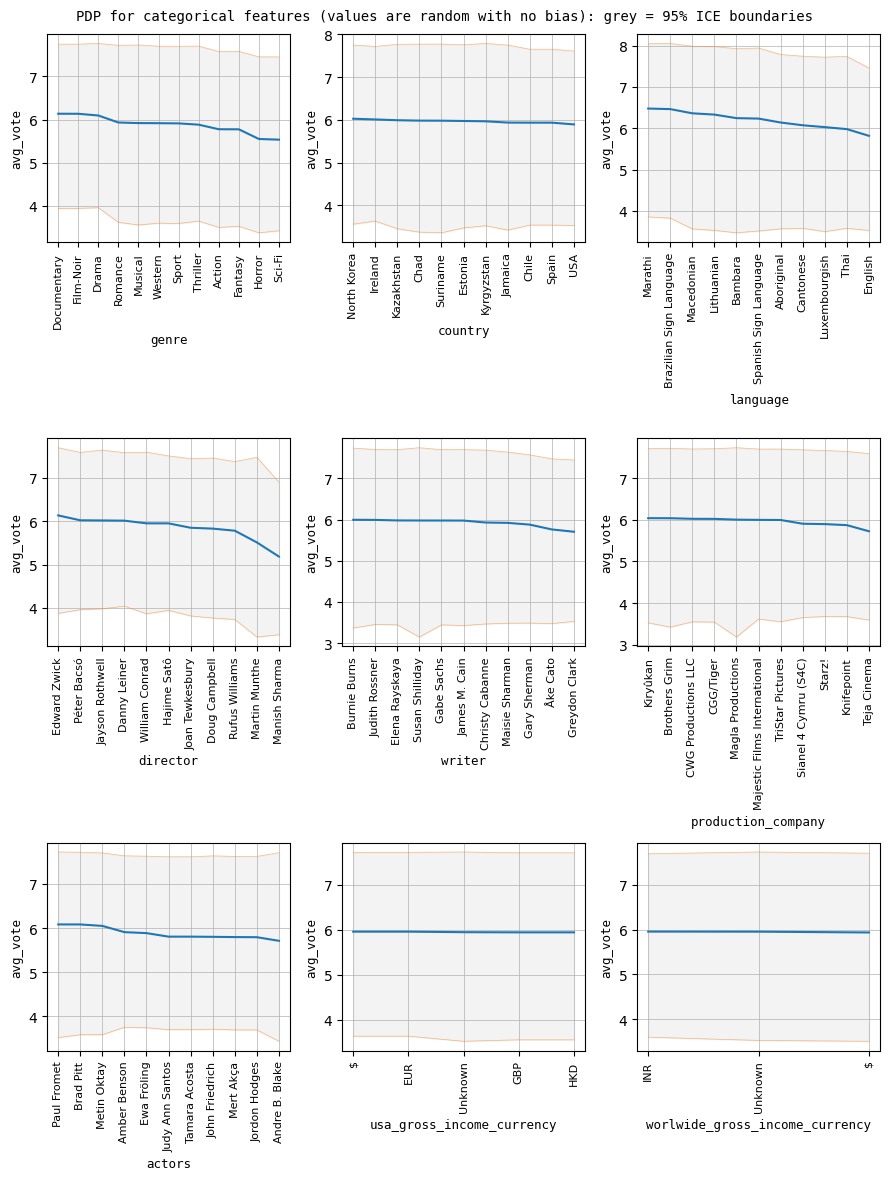

In [104]:
# Categorical features
conf_lvl = 95 # %
ncols = 3
nrows = int(np.ceil(len(cat_cols) / ncols))
plt.figure(figsize=(ncols * 3, nrows * 4))
for i, feature_name in enumerate(cat_cols, start=1):
    plt.subplot(nrows, ncols, i)
    pdp_df = predict_partial(X_train, feature_name, best_estimator, kind='cat', grid_size=10, conf_lvl=conf_lvl).sort_values(by='Pred_mean', ascending=False)
    plt.plot(pdp_df['Value'], pdp_df['Pred_mean'], color='C0')
    # Show Individual Conditional Expectation (ICE) boundaries, as per `conf_lvl`
    plt.plot(pdp_df['Value'], pdp_df['ICE_hi'], color='C1', lw=0.5, alpha=0.5)
    plt.plot(pdp_df['Value'], pdp_df['ICE_lo'], color='C1', lw=0.5, alpha=0.5)
    plt.fill_between(pdp_df['Value'], pdp_df['ICE_hi'], pdp_df['ICE_lo'], color='lightgrey', alpha=0.25)
    plt.xlabel(feature_name, size=9, family='monospace')
    plt.ylabel(target, size=9, family='monospace')
    plt.xticks(size=8, rotation=90)
    plt.suptitle(f'PDP for categorical features (values are random with no bias): grey = {conf_lvl}% ICE boundaries', size=10, family='monospace')
    plt.grid(lw=0.5)
plt.tight_layout();

Interestingly, country such as USA or language such as English does not guarantee high target. At the same time, once again we can confirm that the target does depend on `director`, `genre`, and `production_company`.

---
##### <a id="discuss"></a>6. Discussion

To conclude, we have built a machine learning __model that can explain about 62% of the variance of the target variable `avg_vote` ($R^2_{test} \approx 0.62$)__. Though, this is not a strong model, its independent variables (features) can predict well over than a half of changes in the dependent (target) variable.

As the final algorithm, we have used Gradient Boosting for decision trees. This algorithm appeared to be more successful than linear models, due to discovered non-linear relations between independent features and dependent target. It also outperforms single decision tree and ensemble random forest algorithms. The gradient boosting algorithm builds an ensemble of shallow trees (weak estimators). Unlike in single decision tree algorithm, where only one tree is built, or random forest algorithm, where independent trees are built in parallel, the gradient boosting ensemble is built additively, where each tree is built one after another, allowing to continuously optimize the loss function (mean squared error in our case) using gradient descent.

We have also discovered that __movie's success depends on choosing a talented director working for a top production company making a movie in some popular genre__. We can report these findings to our customer.

Ideas for model's quality improvement:
- try feature selection; it can be very slow in `sklearn` (Python!), so for simplicity it was not used in this assignment;
- try more feature engineering; we attempted to introduce a new feature for `description` but it didn't work out, so, maybe try something else;
- further understand how to transform category text variables; we simply kept the first value, but it might be better to use some NLP technique;
- target encoding, which was used for decision tree based algorithms, is subject to target leakage and thus overfitting; and indeed, even the model with best hyperparameters still overfits ($R^2_{train} \approx 0.84$ vs $R^2_{test} \approx 0.62$), one of the reasons being most likely target encoding; target encoding is better than one-hot encoding for large number of unique categories, but still it needs to be optimized;
- do something with too many missing values in several variables; for example, we did not use `budget` because of too many missing values, but it looks like a valuable predictor; maybe use a more complete and consistent dataset;
- find even a better algorithm than gradient boosting for decision trees.